In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
theano.config.floatX = 'float32'
theano.config.openmp = True

from matplotlib import pyplot as plt
%matplotlib inline



Couldn't import dot_parser, loading of dot files will not be possible.


# configure network
* the network architecture can be read from the architecture tab
 * just one-way successive dense layers, intertwining with dropout layers
   * a dropout layer zeroes-out random neurons each run to avoid overfitting
 * one additional dropout layer is added at the very beginning (right after input)
  
* no proper experiments were done with convolutional layers (CNN)
 * and none will be until we get our GPUs
 * otherwise it takes months to fully train such NN
 
* the network is built using mainly Lasagne and Theano
 * Theano is a mathematical framework for fast resourse-optimized computation
   * A theano algorithm is essentially a computational graph that is automatically optimized and compiled for the available hardware (single-CPU,multi-CPU,GPU, multi-GPU)
   * https://github.com/Theano/Theano
 * Lasagne is a low-level neural network framework, compatible with Theano
   * http://lasagne.readthedocs.org/en/latest/index.html

In [2]:
input_shape = [None,32,32,32]
output_shape = [None,3,1,50]
_input_image_pair = T.tensor4('image_pair',dtype='floatX')
_target = T.tensor4('decay_prediction',dtype='floatX')

## network body

In [3]:
from retina.layers import ChanelwiseSoftmaxLayer

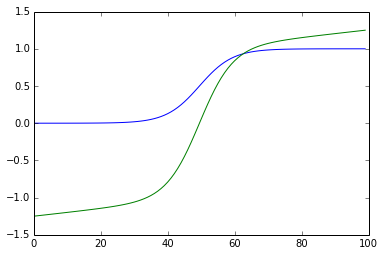

In [4]:
_tanh_zero_one = lambda x: 0.5+lasagne.nonlinearities.ScaledTanH(1,0.5)(x)
_tanh_leaky = lambda x:0.05*x+lasagne.nonlinearities.tanh(x)
plt.plot( _tanh_zero_one(np.linspace(-5,5,100)   ).eval())
plt.plot( _tanh_leaky(np.linspace(-5,5,100)).eval())

In [5]:
#architecture

_nn = lasagne.layers.InputLayer(shape = input_shape,name='input_images',
                                input_var=_input_image_pair)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_inputs",p=0.2)

retina_channel_layers = []
for i in range(_nn.output_shape[1]):
    layer = lasagne.layers.DenseLayer(_nn,name="dense.channel"+str(i),
                                      num_units= 128,
                                      nonlinearity= _tanh_leaky,
    )
    retina_channel_layers.append(layer)
    
_nn = lasagne.layers.ConcatLayer(retina_channel_layers)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_concatenated_channels",p=0.5)


_nn = lasagne.layers.DenseLayer(_nn,name="dense.common.0",
                                num_units = 1024,
                                nonlinearity=lasagne.nonlinearities.sigmoid)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense0",p=0.5)

#_nn = lasagne.layers.DenseLayer(_nn,num_units = 1024,name="dense1",
#                             nonlinearity=lasagne.nonlinearities.sigmoid)

#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense1",p=0.25)




_nn = ChanelwiseSoftmaxLayer( _nn, output_shape[-1])

#_nn = lasagne.layers.DenseLayer(_nn,name="dense_output",
#                                num_units = 150,
#                                nonlinearity=_tanh_zero_one)


_nn = lasagne.layers.ReshapeLayer(_nn,shape = [-1]+output_shape[1:])

In [6]:
# network output function WITH random dropout
#raw shape: [ None,prod(output_shape) ]

_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair)


## optimization objectives

In [7]:
# obtaining optimizable network parameters
_nn_weights = lasagne.layers.get_all_params(_nn,trainable=True)
print _nn_weights

[dense.channel0.W, dense.channel0.b, dense.channel1.W, dense.channel1.b, dense.channel2.W, dense.channel2.b, dense.channel3.W, dense.channel3.b, dense.channel4.W, dense.channel4.b, dense.channel5.W, dense.channel5.b, dense.channel6.W, dense.channel6.b, dense.channel7.W, dense.channel7.b, dense.channel8.W, dense.channel8.b, dense.channel9.W, dense.channel9.b, dense.channel10.W, dense.channel10.b, dense.channel11.W, dense.channel11.b, dense.channel12.W, dense.channel12.b, dense.channel13.W, dense.channel13.b, dense.channel14.W, dense.channel14.b, dense.channel15.W, dense.channel15.b, dense.channel16.W, dense.channel16.b, dense.channel17.W, dense.channel17.b, dense.channel18.W, dense.channel18.b, dense.channel19.W, dense.channel19.b, dense.channel20.W, dense.channel20.b, dense.channel21.W, dense.channel21.b, dense.channel22.W, dense.channel22.b, dense.channel23.W, dense.channel23.b, dense.channel24.W, dense.channel24.b, dense.channel25.W, dense.channel25.b, dense.channel26.W, dense.channe

In [8]:
#constants for tweaking


_shared = lambda name,val: theano.shared(np.float32(val),name,strict = True)

_entropy_weight =_shared("entropy_weight",0)
_l2_weight = _shared("l2_weight",0)


In [10]:
# prediction crossentropy
_crossentropy = lasagne.objectives.categorical_crossentropy(_prediction,_target).mean()



#[unused]
# cosine similarity with normalization applied to prediction only (since target Y is constant)
from retina.compiled import normalize
_prediction_normalized = normalize(_prediction).reshape([-1]+list(output_shape[1:]))
_cosine_similarity = (_prediction_normalized*_target).sum()


# all non-regularization terms
_unregularized_loss = _crossentropy


In [11]:
# regularizers

###entropy-based regularizer
#prediction entropy
_prediction_channels_entropy = lasagne.objectives.categorical_crossentropy(_prediction,_prediction)

#target entropy
_target_soft = (_target + 0.0001) #avoiding hard zeroes
_target_soft = _target_soft / T.sum(_target_soft,axis=-1,keepdims=True) #normalizing

_target_channels_entropy = lasagne.objectives.categorical_crossentropy(_target_soft,_target_soft)


_entropy_mse_over_channels = (_prediction_channels_entropy-_target_channels_entropy)**2

_entropy_penalty = _entropy_mse_over_channels.mean()

_reg_entropy = _entropy_penalty * _entropy_weight


# L2 (Tikhonov) regularizer
_weight_l2 = lasagne.regularization.regularize_network_params(_nn,
                            penalty = lasagne.regularization.l2)
_reg_l2 = _weight_l2 * _l2_weight






_loss = _unregularized_loss

if _l2_weight.get_value()!= 0:
    _loss += _reg_l2
if _entropy_weight.get_value() !=0:
    _loss += _reg_entropy
    

In [12]:
# optimization algorithm
_nn_update = lasagne.updates.nesterov_momentum(_loss,
                                               params = _nn_weights,
                                               learning_rate = .01
                                              )

In [13]:
# compiled optimization algorithm
train_fun = theano.function([_input_image_pair,_target],
                            _loss,
                            updates=_nn_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

In [14]:
# network output function WITHOUT dropout 
# dropout gets replaced with reweighting all outputs by (1 - P(drop) )
# thus, the output becomes DETERMINISTIC and uses whole network
_det_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair,deterministic=True)

# compiled deterministic output function (for evaluation and prediction)
predict = theano.function([_input_image_pair],_det_prediction)

## evaluation functions

In [15]:
from sklearn.metrics import roc_auc_score,accuracy_score

_prediction_entropy = _prediction_channels_entropy.mean()

metrics = [_loss,_unregularized_loss,
           _reg_entropy,
           _reg_l2,
           _det_prediction]

score_fun = theano.function([_input_image_pair,_target],
                             metrics,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

from retina.extremum import get_maxima
from sklearn.metrics import roc_auc_score
def pseudo_auc_score(y,y_pred):
    """just a probability that a random maxima will be rated by nn above a random non-maximum
    NOTE - in this case, the nn output is scaled to the norm of true output because
    predictions are normalized. 
    THAT DOES INTRODUCE A BIAS IN EVALUATION"""
    y_norms = np.linalg.norm(y,axis=-1,ord=1)[...,np.newaxis]
    y_pred *= y_norms

    true_maxima = get_maxima(y)#alarm - it's padded, last coord is true_coord-2
    true_maxima[-1] +=1 #account for padding

    true_selector = np.zeros_like(y,dtype=bool)
    true_selector[true_maxima]=1
    
    return roc_auc_score(true_selector.ravel(),y_pred.ravel())


def evaluate(X,y_targ):
    
    score,unreg_score,reg_entropy,reg_l2,y_pred = score_fun(X,y_targ)
    print 'full loss:',score
    print 'detection loss:',unreg_score
    print 'entropy penalty:',reg_entropy
    print 'l2 penalty:',reg_l2
    print 'pseudo-auc',pseudo_auc_score(y_targ,y_pred)
    
    return unreg_score
    

# fetch data
* load several retina images, concatenate them into pairs
 * a pair consists of two retina images of the SAME event
 * the difference is the position and orientation of the retina grid
* the retina images are 32x32 pixels each

In [16]:
img_folder = "/mnt/KSfinder/finder/retinas_randomized/"
import os
X = np.load(os.path.join(img_folder,"ksfinder_images.npy"))
y = np.load(os.path.join(img_folder,"ksfinder_targets.npy"))
print X.shape,y.shape

(5635, 32, 32, 32) (5635, 3, 50)


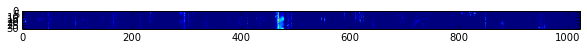

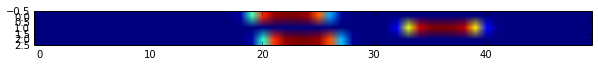

In [17]:
i = 0
plt.figure(figsize=[10,3])
plt.imshow(np.hstack(X[i]))
plt.show()
plt.figure(figsize=[10,3])
plt.imshow(np.vstack(y[i]))
plt.show()

In [18]:
#setup data format
X= X.reshape(-1,*input_shape[1:]).astype('float32')
y = y.reshape(-1,*output_shape[1:]).astype('float32')
print X.shape,y.shape

(5635, 32, 32, 32) (5635, 3, 1, 50)


In [19]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.2,random_state=42)

# train it
* by iteratively picking minibatches and training on them
* the method used for iterations is
 * Stochastic Gradient Descent (SGD) updates with Nesterov momentum
 * used it just because i heard it's good, no actual analysis done
* Uniform additive l2 regularization is applied to the network to prevent overfitting as well
 * regularization constant was briefly tweaked via crossvalidation for ROC AUC
 * more sophisticated regularizers were not analyzed

In [20]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [21]:
import random
def show_sample_predictions(X,y,count=10,cmap='GnBu'):
    
    #select samples to show
    sample_indices = np.random.randint(0,len(y)-1,count)

    y_pred = predict(X[sample_indices])
    
    y = y[sample_indices]
    y/=np.linalg.norm(y,axis=-1,keepdims=True)
    
    
    for i in range(count):

        plt.figure(figsize=[15,2])
        plt.imshow(y[i].reshape(-1,50),interpolation='none')#,cmap=cmap)
        plt.title('sample %i reference'%sample_indices[i])
        plt.colorbar()
        plt.show()

        plt.figure(figsize=[15,2])
        plt.imshow(y_pred[i].reshape(-1,50),interpolation='none')#,cmap=cmap)
        plt.title('sample %i prediction'%sample_indices[i])
        plt.colorbar()
        plt.show()

In [22]:
#global epoch counter (useful if several train loops were started in succession)
epochCounter = 0
train_scores = {}
test_scores = {}

In [24]:
import time
for i in range(240):#to prevent unstoppable sleep
    time.sleep(60)

train loss during epoch 0 : 44.108089
train loss during epoch 0 : 41.908264
train loss during epoch 0 : 41.053207
train loss during epoch 0 : 39.661678
train loss during epoch 0 : 39.382267
train loss during epoch 0 : 39.382530
train loss during epoch 0 : 39.245911
train loss during epoch 0 : 38.984695
train loss during epoch 0 : 39.139088
train loss during epoch 0 : 38.601261
train loss during epoch 0 : 38.230278
train loss during epoch 0 : 37.903316
train loss during epoch 0 : 37.636497
train loss during epoch 0 : 37.421627
train loss during epoch 0 : 37.106899
train loss during epoch 0 : 36.865128
train loss during epoch 0 : 36.814606
train loss during epoch 0 : 36.867905
train loss during epoch 0 : 36.746513
train loss during epoch 0 : 36.763119
train loss during epoch 0 : 36.729958
train loss during epoch 0 : 36.688267
train loss during epoch 0 : 36.658695
train loss during epoch 0 : 36.605473
train loss during epoch 0 : 36.549644
train loss during epoch 0 : 36.492695
train loss d

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


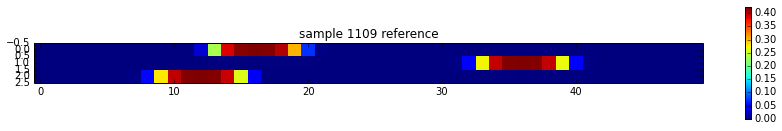

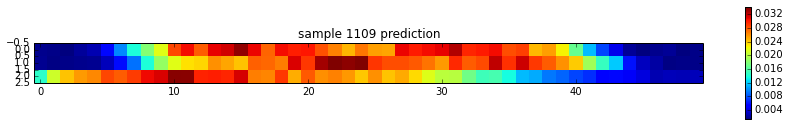

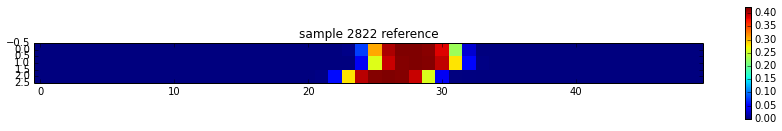

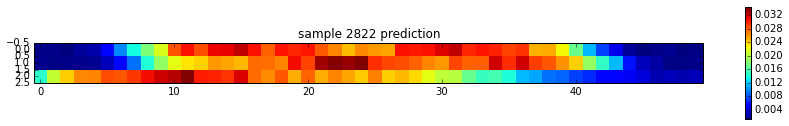

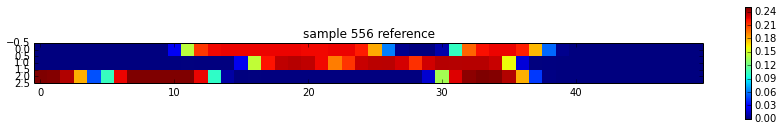

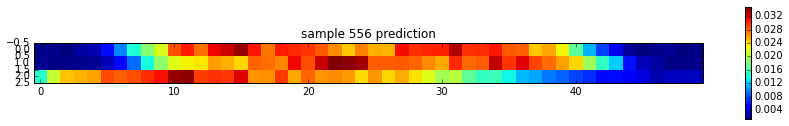

test score:
full loss: 36.066444397
detection loss: 36.066444397
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.729456290294



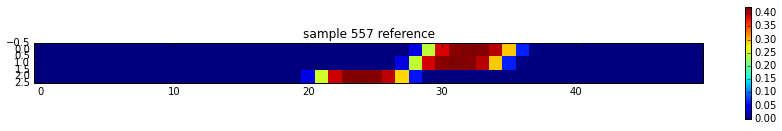

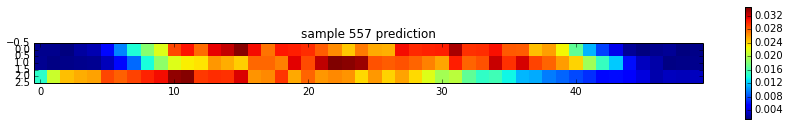

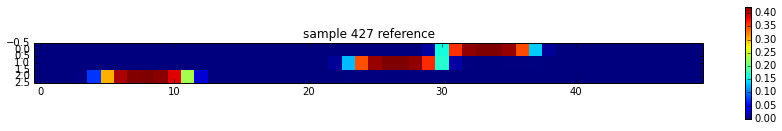

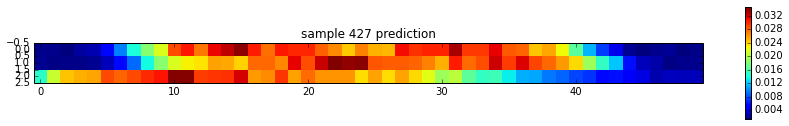

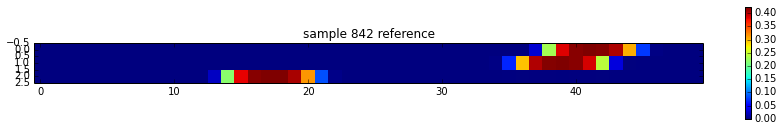

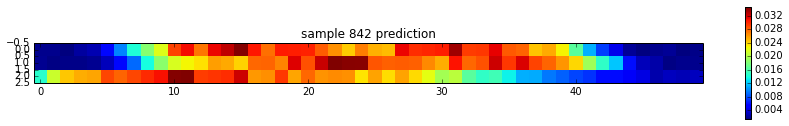

.........................
train loss during epoch 1 : 35.882175
train loss during epoch 1 : 35.850258
train loss during epoch 1 : 35.416824
train loss during epoch 1 : 35.277435
train loss during epoch 1 : 35.037827
train loss during epoch 1 : 35.263508
train loss during epoch 1 : 34.797203
train loss during epoch 1 : 34.463951
train loss during epoch 1 : 34.739777
train loss during epoch 1 : 34.841961
train loss during epoch 1 : 35.232624
train loss during epoch 1 : 35.402210
train loss during epoch 1 : 35.365875
train loss during epoch 1 : 35.458401
train loss during epoch 1 : 35.256264
train loss during epoch 1 : 35.259781
train loss during epoch 1 : 35.153706
train loss during epoch 1 : 35.061344
train loss during epoch 1 : 35.108212
train loss during epoch 1 : 35.258598
train loss during epoch 1 : 35.164204
train loss during epoch 1 : 35.294918
train loss during epoch 1 : 35.212902
train loss during epoch 1 : 35.123287
train loss during epoch 1 : 35.099091
train loss during epoch 

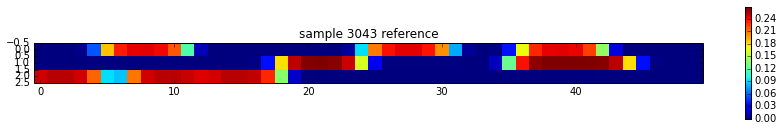

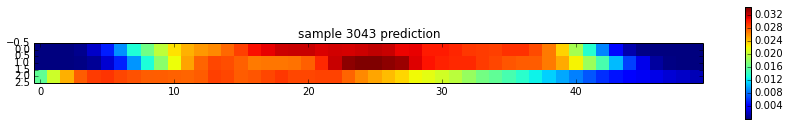

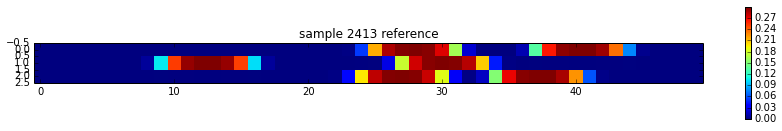

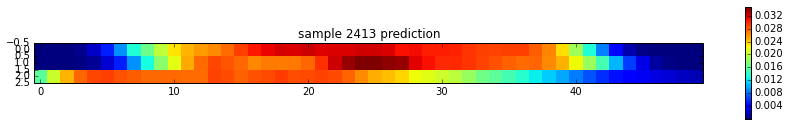

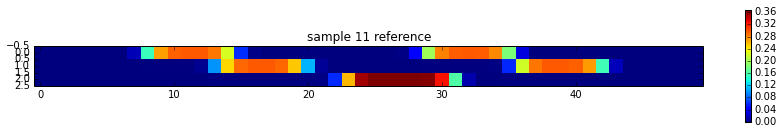

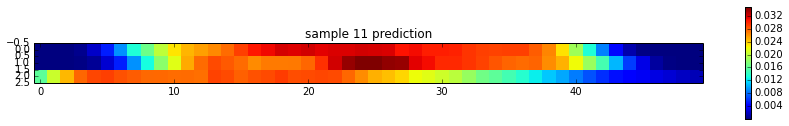

test score:
full loss: 35.719078064
detection loss: 35.719078064
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.729129514296



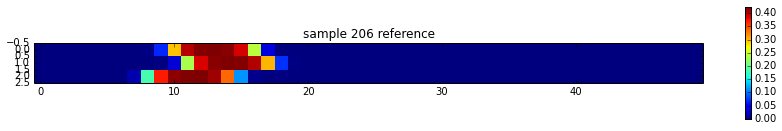

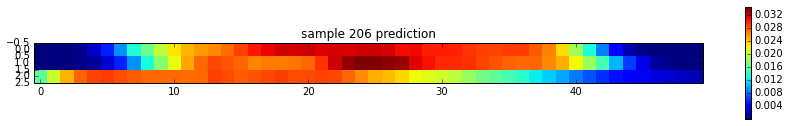

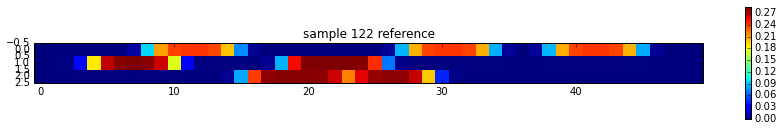

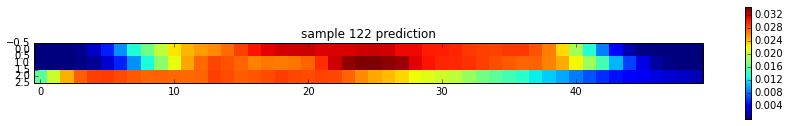

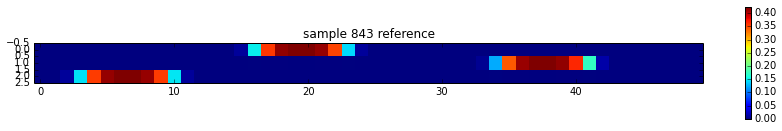

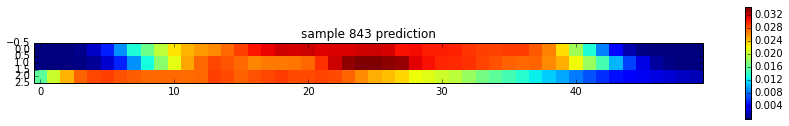

.........................
train loss during epoch 11 : 34.223061
train loss during epoch 11 : 34.829514
train loss during epoch 11 : 35.394989
train loss during epoch 11 : 35.146389
train loss during epoch 11 : 34.927162
train loss during epoch 11 : 35.128738
train loss during epoch 11 : 35.074162
train loss during epoch 11 : 35.241646
train loss during epoch 11 : 35.160023
train loss during epoch 11 : 35.030602
train loss during epoch 11 : 34.855434
train loss during epoch 11 : 34.914833
train loss during epoch 11 : 35.081852
train loss during epoch 11 : 35.007824
train loss during epoch 11 : 34.989796
train loss during epoch 11 : 34.940926
train loss during epoch 11 : 34.968502
train loss during epoch 11 : 35.075375
train loss during epoch 11 : 35.036583
train loss during epoch 11 : 35.035500
train loss during epoch 11 : 35.085491
train loss during epoch 11 : 34.969650
train loss during epoch 11 : 35.077213
train loss during epoch 11 : 35.181210
train loss during epoch 11 : 35.231434

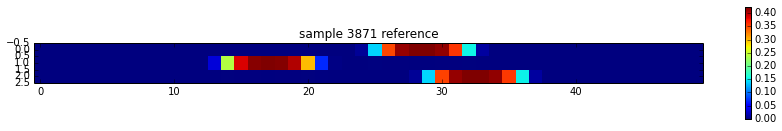

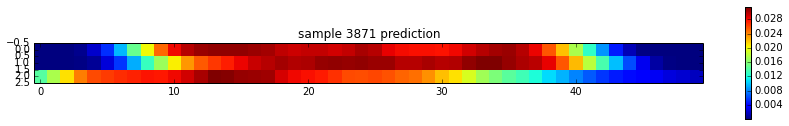

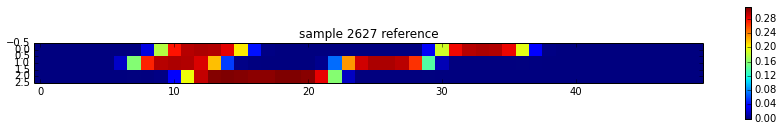

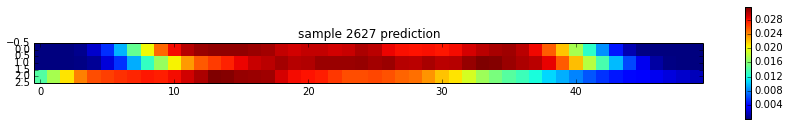

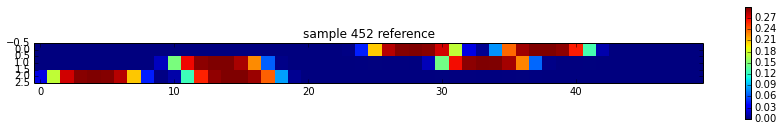

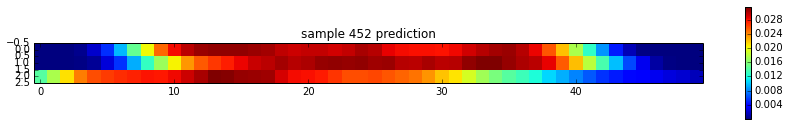

test score:
full loss: 35.7205924988
detection loss: 35.7205924988
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728986761115



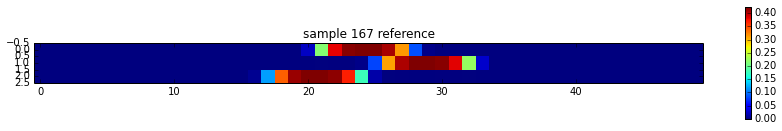

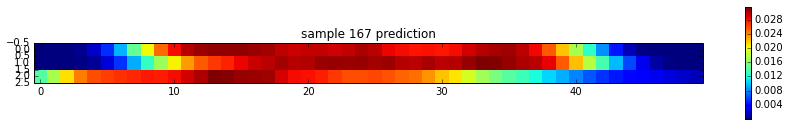

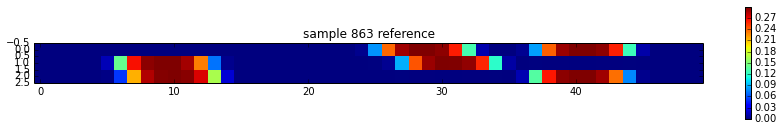

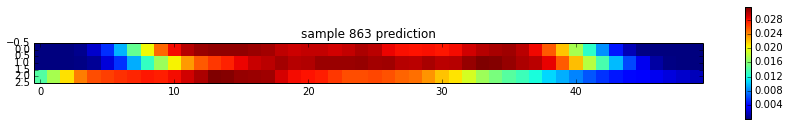

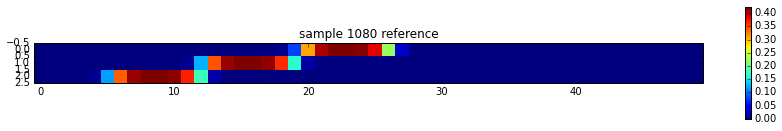

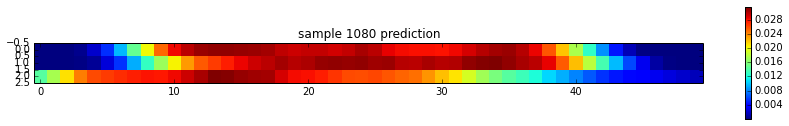

.........................
train loss during epoch 21 : 34.779995
train loss during epoch 21 : 34.519104
train loss during epoch 21 : 34.242580
train loss during epoch 21 : 34.505402
train loss during epoch 21 : 35.038170
train loss during epoch 21 : 34.920582
train loss during epoch 21 : 34.569958
train loss during epoch 21 : 34.467876
train loss during epoch 21 : 34.498123
train loss during epoch 21 : 34.614460
train loss during epoch 21 : 34.783321
train loss during epoch 21 : 34.915981
train loss during epoch 21 : 35.076836
train loss during epoch 21 : 34.917744
train loss during epoch 21 : 34.899128
train loss during epoch 21 : 35.004803
train loss during epoch 21 : 34.901436
train loss during epoch 21 : 35.141426
train loss during epoch 21 : 35.081142
train loss during epoch 21 : 35.019299
train loss during epoch 21 : 35.078232
train loss during epoch 21 : 35.071266
train loss during epoch 21 : 35.130993
train loss during epoch 21 : 34.995815
train loss during epoch 21 : 34.876987

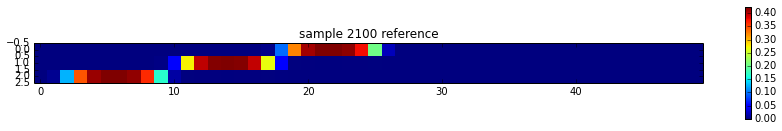

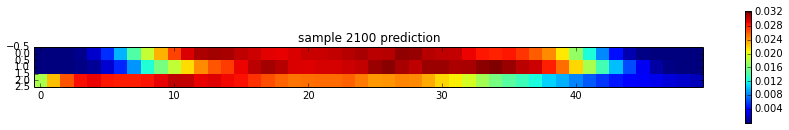

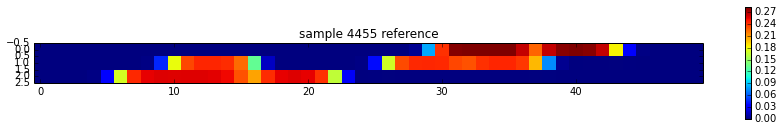

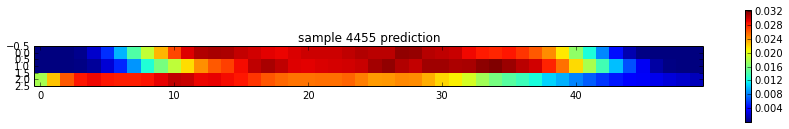

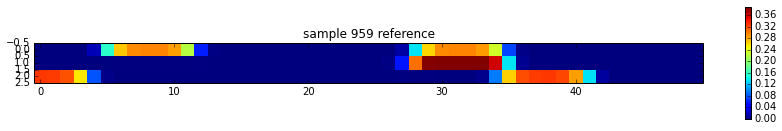

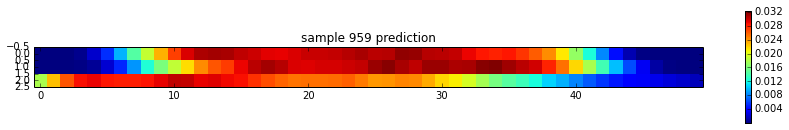

test score:
full loss: 35.7344856262
detection loss: 35.7344856262
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.72840331262



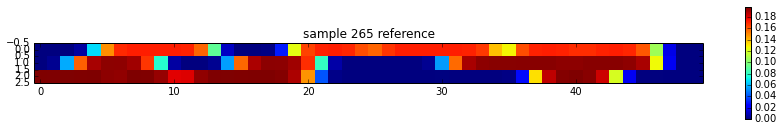

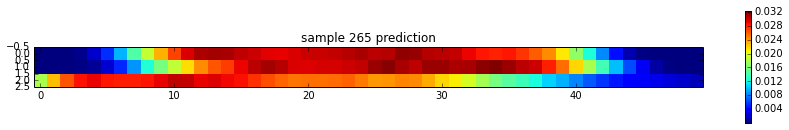

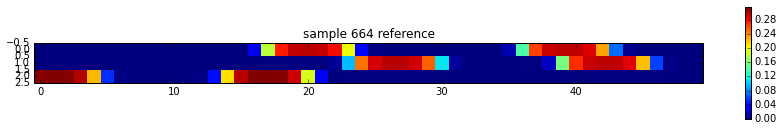

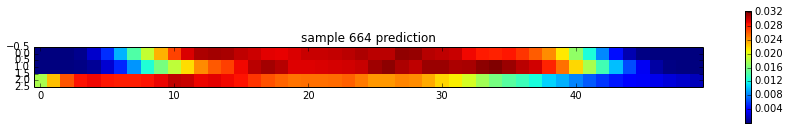

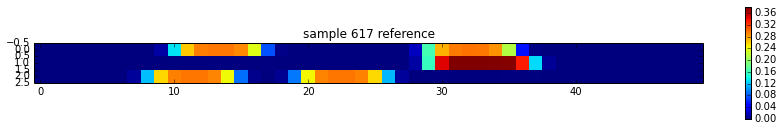

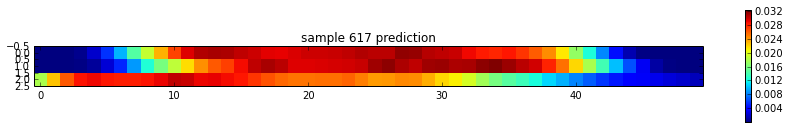

.........................
train loss during epoch 31 : 33.219143
train loss during epoch 31 : 32.689209
train loss during epoch 31 : 33.344223
train loss during epoch 31 : 33.674217
train loss during epoch 31 : 33.683586
train loss during epoch 31 : 34.006657
train loss during epoch 31 : 34.039482
train loss during epoch 31 : 33.756851
train loss during epoch 31 : 33.707745
train loss during epoch 31 : 34.225685
train loss during epoch 31 : 34.641045
train loss during epoch 31 : 34.656269
train loss during epoch 31 : 34.639603
train loss during epoch 31 : 34.590595
train loss during epoch 31 : 34.576656
train loss during epoch 31 : 34.390255
train loss during epoch 31 : 34.465923
train loss during epoch 31 : 34.491684
train loss during epoch 31 : 34.394661
train loss during epoch 31 : 34.555035
train loss during epoch 31 : 34.668076
train loss during epoch 31 : 34.653004
train loss during epoch 31 : 34.687080
train loss during epoch 31 : 34.786251
train loss during epoch 31 : 34.869003

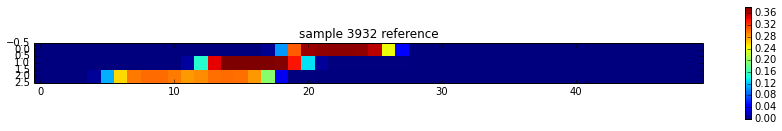

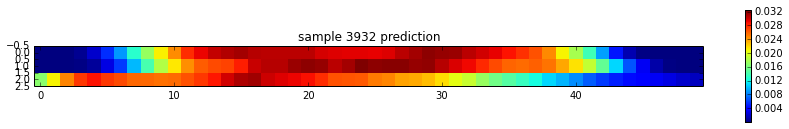

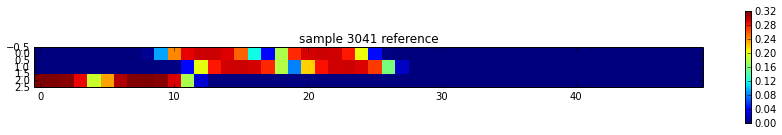

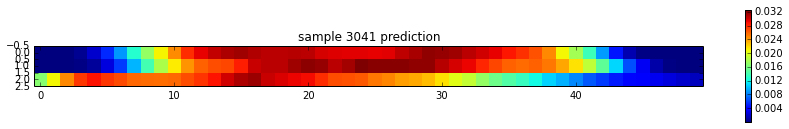

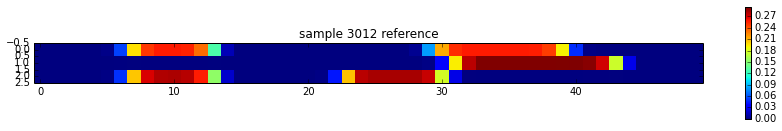

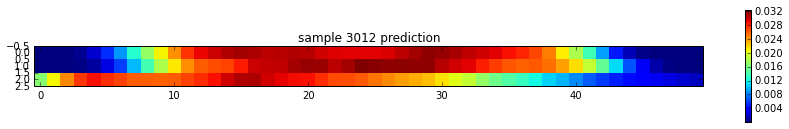

test score:
full loss: 35.7083625793
detection loss: 35.7083625793
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728769691996



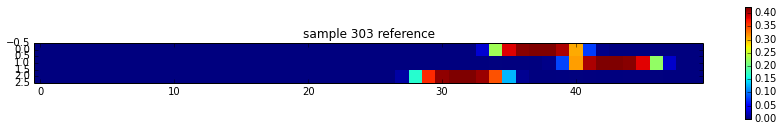

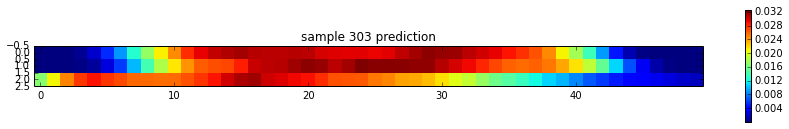

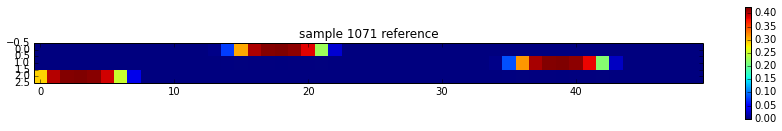

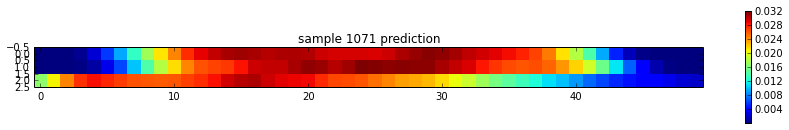

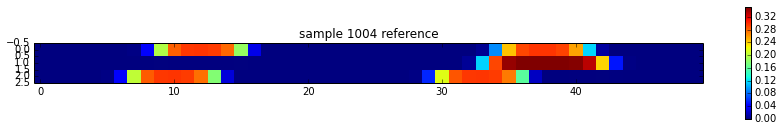

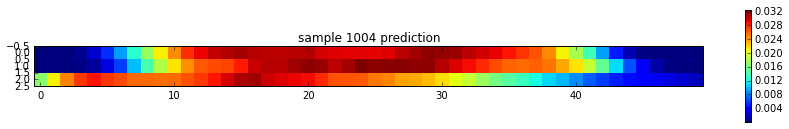

.........................
train loss during epoch 41 : 35.467289
train loss during epoch 41 : 35.572067
train loss during epoch 41 : 35.492123
train loss during epoch 41 : 35.934013
train loss during epoch 41 : 36.061394
train loss during epoch 41 : 35.664852
train loss during epoch 41 : 35.466454
train loss during epoch 41 : 35.187817
train loss during epoch 41 : 34.909103
train loss during epoch 41 : 34.918571
train loss during epoch 41 : 35.151073
train loss during epoch 41 : 35.081272
train loss during epoch 41 : 35.247292
train loss during epoch 41 : 35.256138
train loss during epoch 41 : 35.140911
train loss during epoch 41 : 34.998795
train loss during epoch 41 : 35.083866
train loss during epoch 41 : 35.050735
train loss during epoch 41 : 35.152622
train loss during epoch 41 : 35.130051
train loss during epoch 41 : 35.142284
train loss during epoch 41 : 35.240242
train loss during epoch 41 : 35.230213
train loss during epoch 41 : 35.225857
train loss during epoch 41 : 35.175365

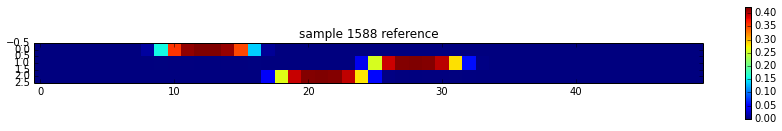

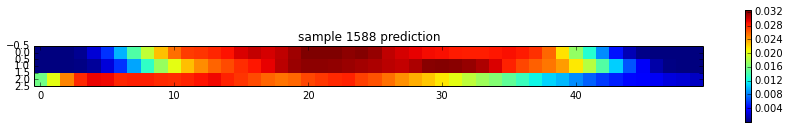

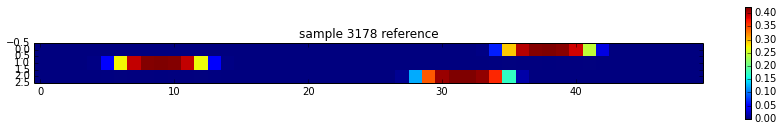

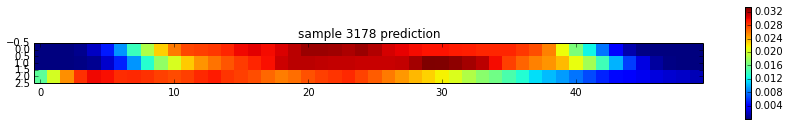

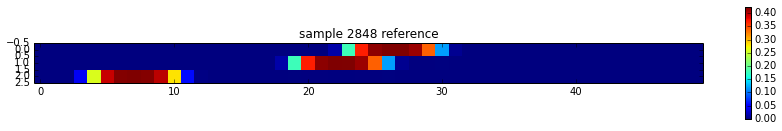

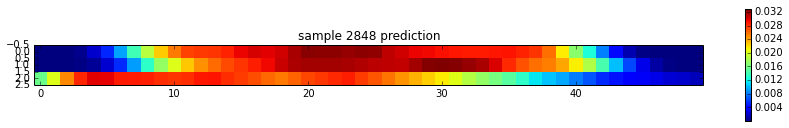

test score:
full loss: 35.7331237793
detection loss: 35.7331237793
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.729558974648



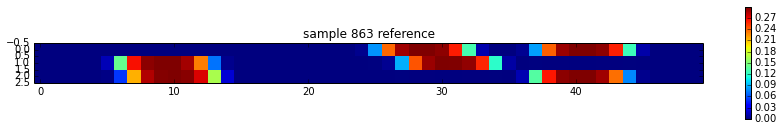

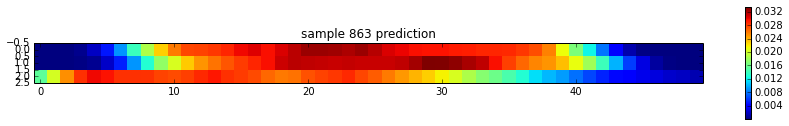

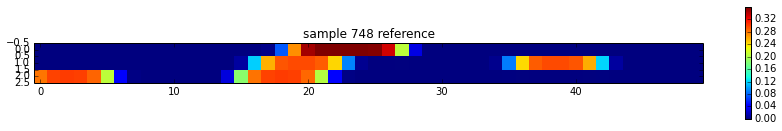

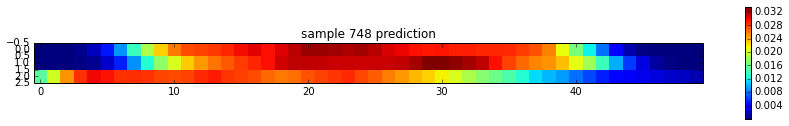

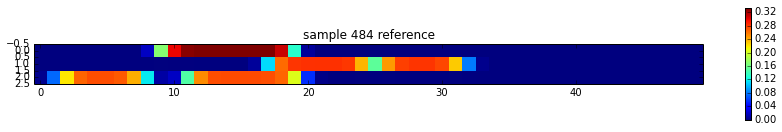

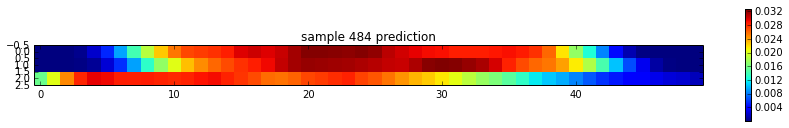

.........................
train loss during epoch 51 : 34.597862
train loss during epoch 51 : 35.309155
train loss during epoch 51 : 34.907177
train loss during epoch 51 : 34.452568
train loss during epoch 51 : 34.289112
train loss during epoch 51 : 34.579468
train loss during epoch 51 : 34.532444
train loss during epoch 51 : 34.424034
train loss during epoch 51 : 34.322437
train loss during epoch 51 : 34.359207
train loss during epoch 51 : 34.448902
train loss during epoch 51 : 34.549149
train loss during epoch 51 : 34.612785
train loss during epoch 51 : 34.563190
train loss during epoch 51 : 34.569271
train loss during epoch 51 : 34.567711
train loss during epoch 51 : 34.737518
train loss during epoch 51 : 34.799721
train loss during epoch 51 : 34.744312
train loss during epoch 51 : 34.669144
train loss during epoch 51 : 34.684254
train loss during epoch 51 : 34.673504
train loss during epoch 51 : 34.711449
train loss during epoch 51 : 34.766621
train loss during epoch 51 : 34.925995

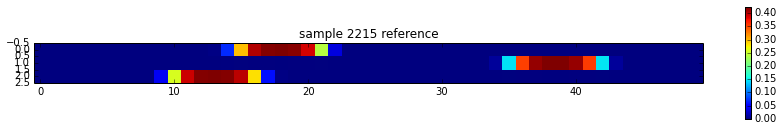

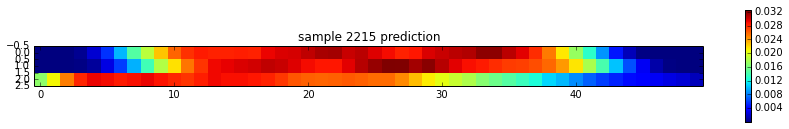

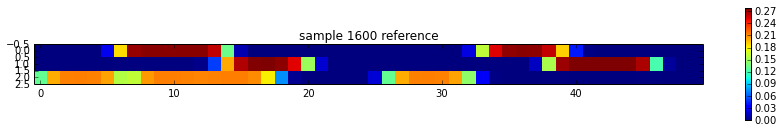

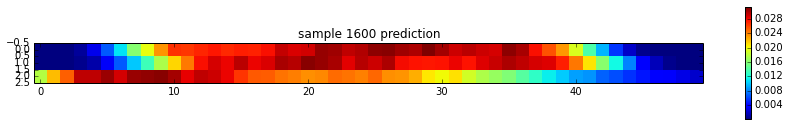

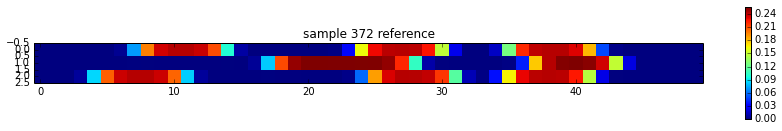

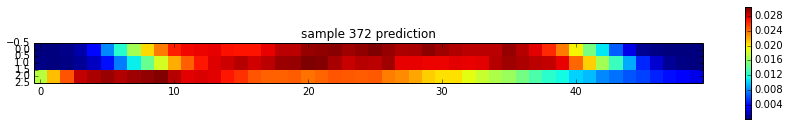

test score:
full loss: 35.7117347717
detection loss: 35.7117347717
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728724701163



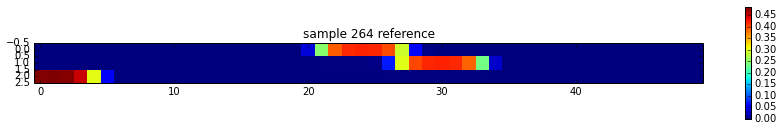

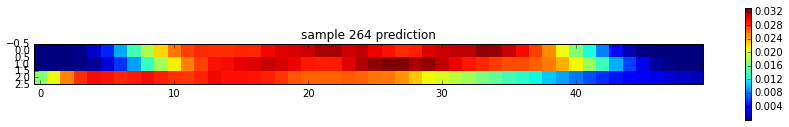

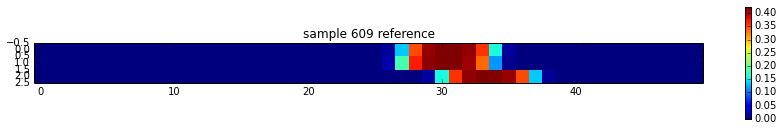

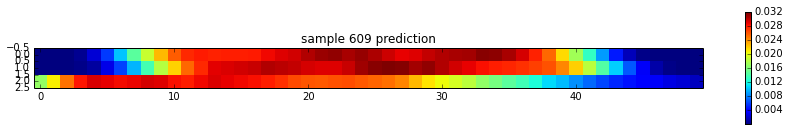

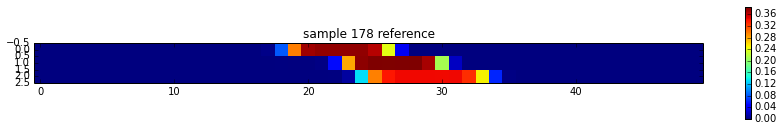

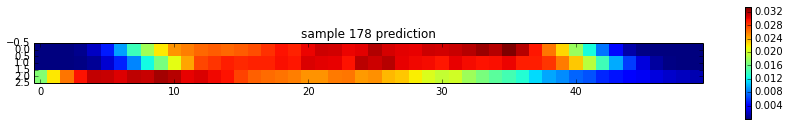

.........................
train loss during epoch 61 : 34.318153
train loss during epoch 61 : 33.929943
train loss during epoch 61 : 33.603931
train loss during epoch 61 : 33.565044
train loss during epoch 61 : 33.713032
train loss during epoch 61 : 34.172924
train loss during epoch 61 : 34.462559
train loss during epoch 61 : 34.670166
train loss during epoch 61 : 34.431679
train loss during epoch 61 : 34.509369
train loss during epoch 61 : 34.652084
train loss during epoch 61 : 34.578472
train loss during epoch 61 : 34.712898
train loss during epoch 61 : 34.678547
train loss during epoch 61 : 34.821583
train loss during epoch 61 : 34.940327
train loss during epoch 61 : 34.966843
train loss during epoch 61 : 35.094421
train loss during epoch 61 : 35.099461
train loss during epoch 61 : 35.115719
train loss during epoch 61 : 35.117485
train loss during epoch 61 : 35.035000
train loss during epoch 61 : 34.980114
train loss during epoch 61 : 34.946335
train loss during epoch 61 : 35.064587

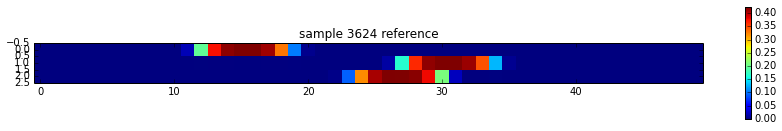

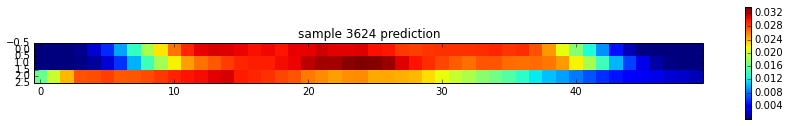

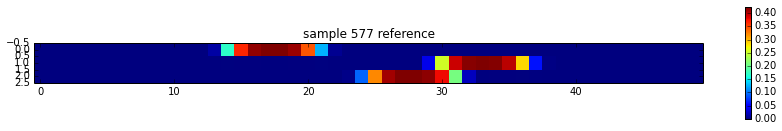

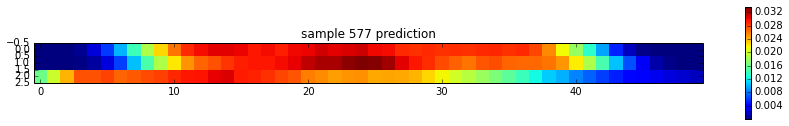

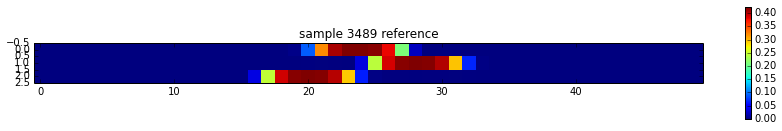

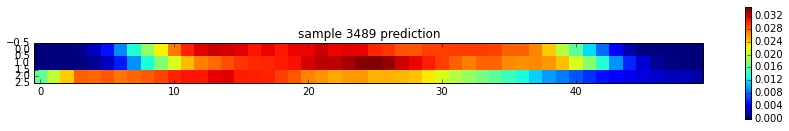

test score:
full loss: 35.7228927612
detection loss: 35.7228927612
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728327997405



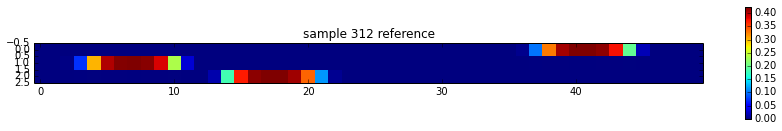

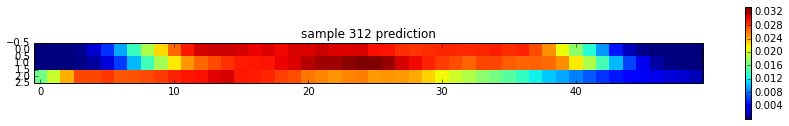

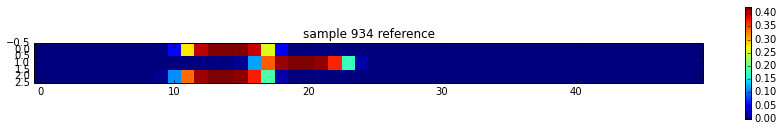

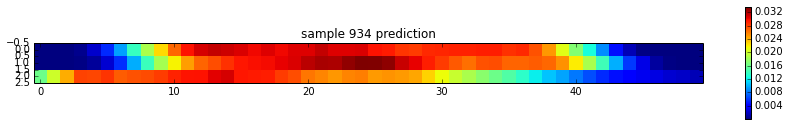

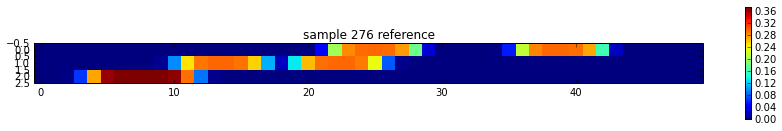

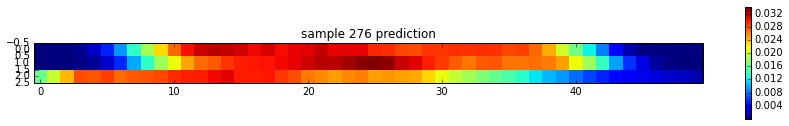

.........................
train loss during epoch 71 : 38.112713
train loss during epoch 71 : 37.976112
train loss during epoch 71 : 37.162579
train loss during epoch 71 : 36.547932
train loss during epoch 71 : 35.916714
train loss during epoch 71 : 35.255535
train loss during epoch 71 : 34.948376
train loss during epoch 71 : 34.951561
train loss during epoch 71 : 34.915894
train loss during epoch 71 : 34.980583
train loss during epoch 71 : 34.864193
train loss during epoch 71 : 35.021885
train loss during epoch 71 : 35.187233
train loss during epoch 71 : 34.931576
train loss during epoch 71 : 35.023720
train loss during epoch 71 : 34.903542
train loss during epoch 71 : 35.098305
train loss during epoch 71 : 35.228092
train loss during epoch 71 : 34.983147
train loss during epoch 71 : 35.030125
train loss during epoch 71 : 34.959648
train loss during epoch 71 : 34.899387
train loss during epoch 71 : 34.947498
train loss during epoch 71 : 34.911366
train loss during epoch 71 : 34.976376

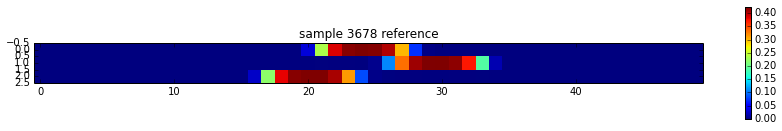

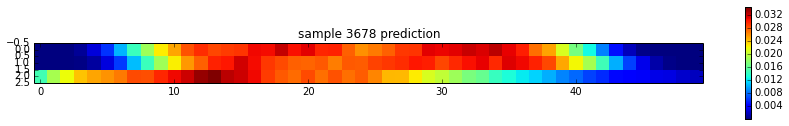

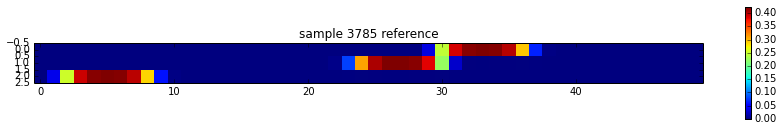

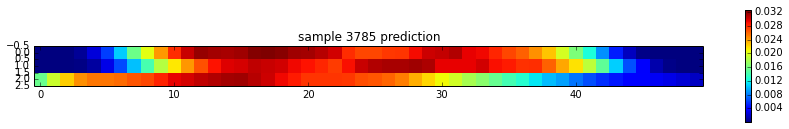

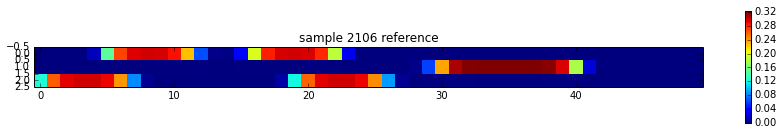

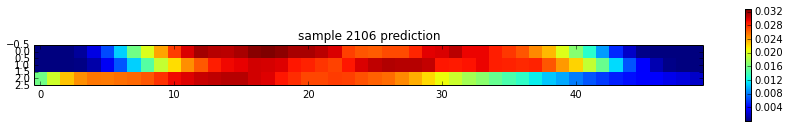

test score:
full loss: 35.7449455261
detection loss: 35.7449455261
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728616787103



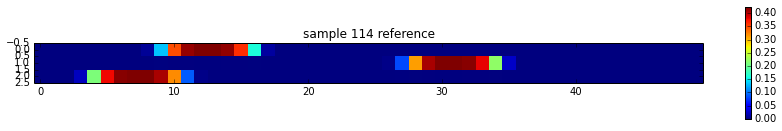

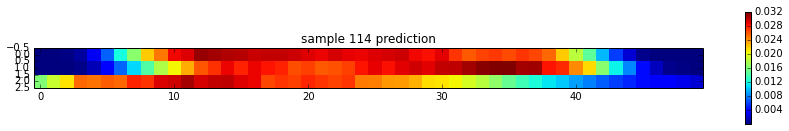

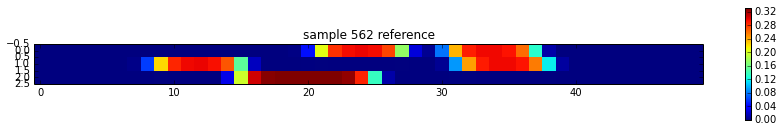

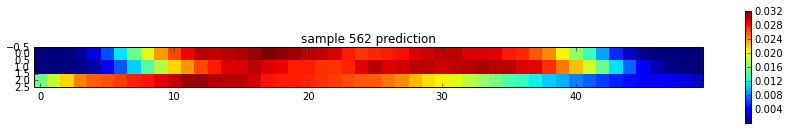

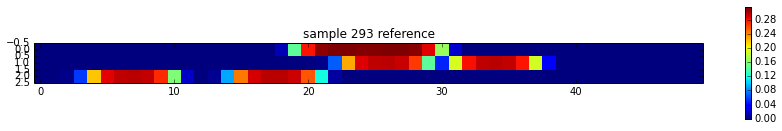

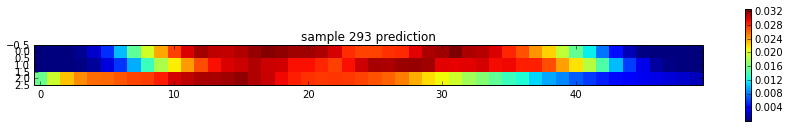

.........................
train loss during epoch 81 : 34.785580
train loss during epoch 81 : 33.781101
train loss during epoch 81 : 35.017918
train loss during epoch 81 : 35.847874
train loss during epoch 81 : 35.370651
train loss during epoch 81 : 35.122234
train loss during epoch 81 : 35.059628
train loss during epoch 81 : 35.018322
train loss during epoch 81 : 34.810528
train loss during epoch 81 : 34.700500
train loss during epoch 81 : 35.073898
train loss during epoch 81 : 35.005035
train loss during epoch 81 : 35.028126
train loss during epoch 81 : 35.088509
train loss during epoch 81 : 35.066811
train loss during epoch 81 : 35.198601
train loss during epoch 81 : 35.103920
train loss during epoch 81 : 35.157875
train loss during epoch 81 : 35.265381
train loss during epoch 81 : 35.227463
train loss during epoch 81 : 35.200150
train loss during epoch 81 : 35.146347
train loss during epoch 81 : 35.122490
train loss during epoch 81 : 35.016483
train loss during epoch 81 : 34.915108

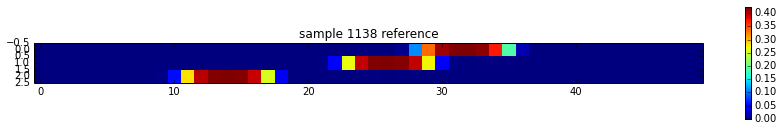

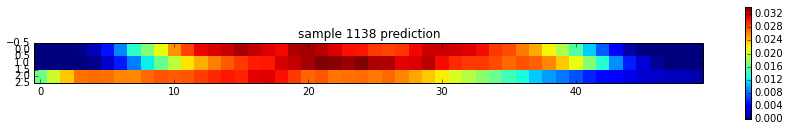

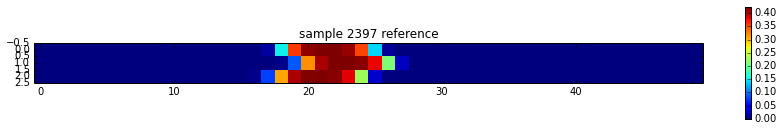

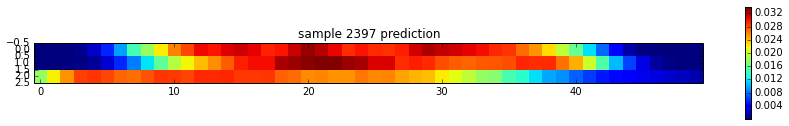

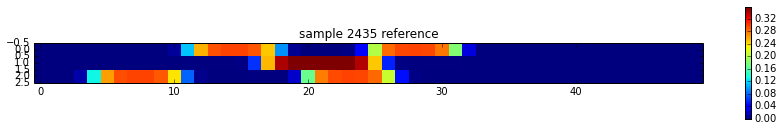

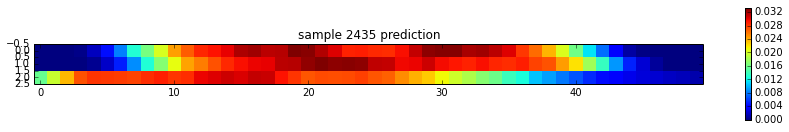

test score:
full loss: 35.7629127502
detection loss: 35.7629127502
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.72847731606



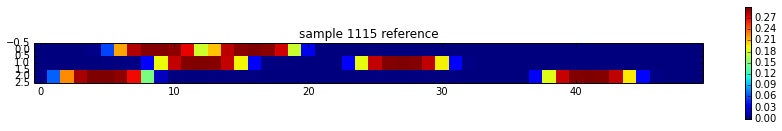

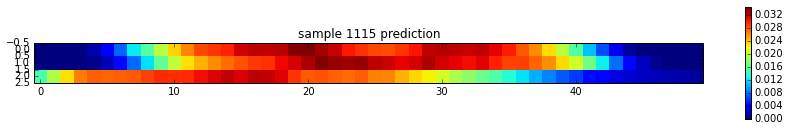

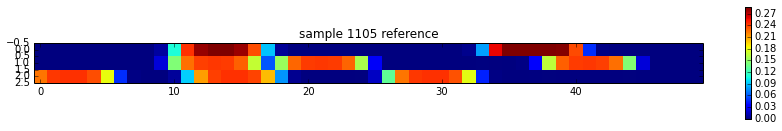

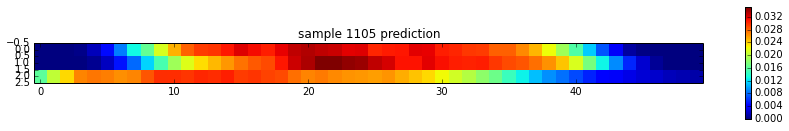

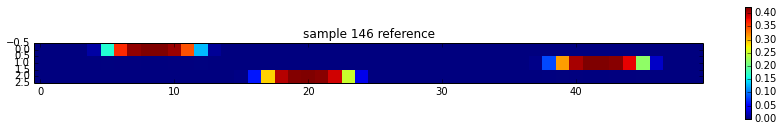

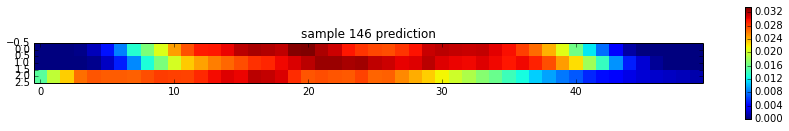

.........................
train loss during epoch 91 : 31.722908
train loss during epoch 91 : 33.199352
train loss during epoch 91 : 33.303379
train loss during epoch 91 : 33.575897
train loss during epoch 91 : 33.981228
train loss during epoch 91 : 34.162533
train loss during epoch 91 : 34.472713
train loss during epoch 91 : 34.443253
train loss during epoch 91 : 34.716892
train loss during epoch 91 : 34.518497
train loss during epoch 91 : 34.635735
train loss during epoch 91 : 34.616032
train loss during epoch 91 : 34.872925
train loss during epoch 91 : 34.813461
train loss during epoch 91 : 34.908092
train loss during epoch 91 : 34.995461
train loss during epoch 91 : 34.819908
train loss during epoch 91 : 35.002762
train loss during epoch 91 : 34.823078
train loss during epoch 91 : 34.680958
train loss during epoch 91 : 34.755222
train loss during epoch 91 : 34.731640
train loss during epoch 91 : 34.724148
train loss during epoch 91 : 34.714230
train loss during epoch 91 : 34.698013

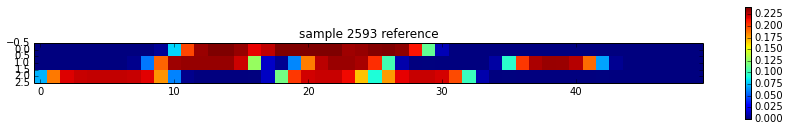

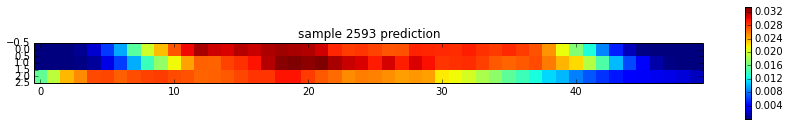

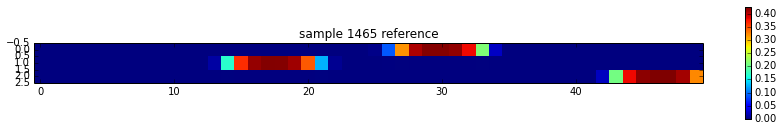

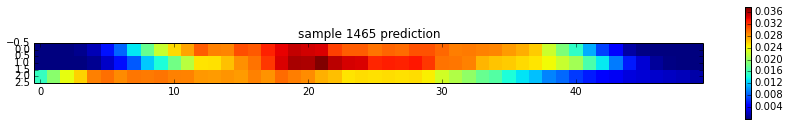

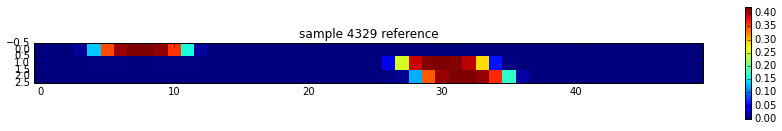

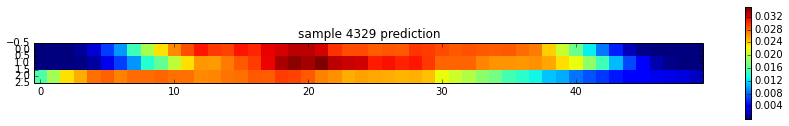

test score:
full loss: 35.8321762085
detection loss: 35.8321762085
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.727485862865



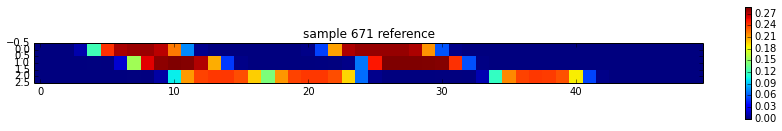

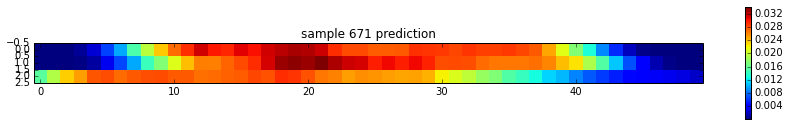

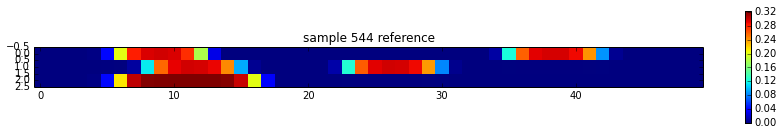

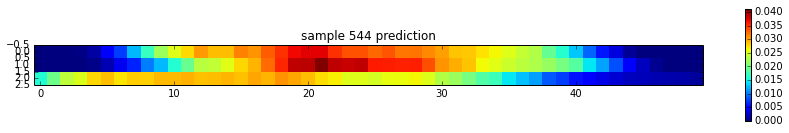

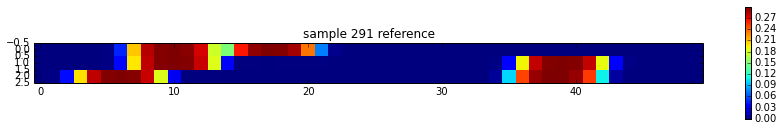

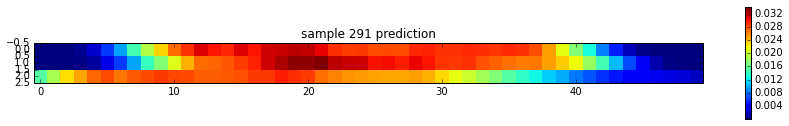

.........................
train loss during epoch 101 : 36.538296
train loss during epoch 101 : 35.916473
train loss during epoch 101 : 35.733368
train loss during epoch 101 : 35.617409
train loss during epoch 101 : 35.781013
train loss during epoch 101 : 35.754726
train loss during epoch 101 : 35.700367
train loss during epoch 101 : 35.415543
train loss during epoch 101 : 35.169323
train loss during epoch 101 : 35.145397
train loss during epoch 101 : 35.021500
train loss during epoch 101 : 35.200836
train loss during epoch 101 : 35.218418
train loss during epoch 101 : 35.116009
train loss during epoch 101 : 35.062752
train loss during epoch 101 : 35.133545
train loss during epoch 101 : 35.221230
train loss during epoch 101 : 35.287251
train loss during epoch 101 : 35.203251
train loss during epoch 101 : 35.336956
train loss during epoch 101 : 35.326447
train loss during epoch 101 : 35.285995
train loss during epoch 101 : 35.247528
train loss during epoch 101 : 35.231987
train loss dur

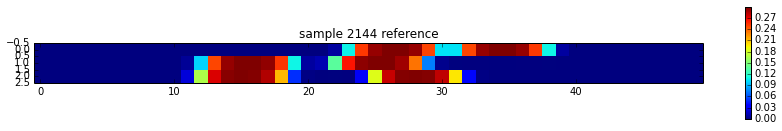

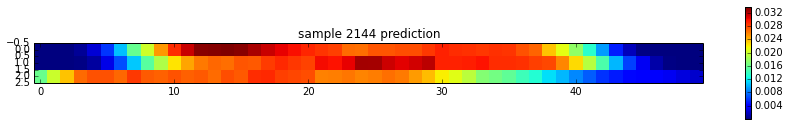

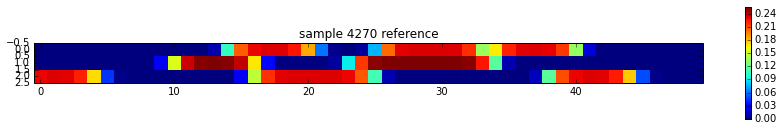

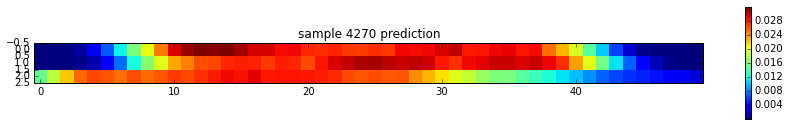

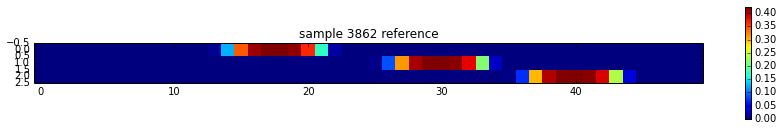

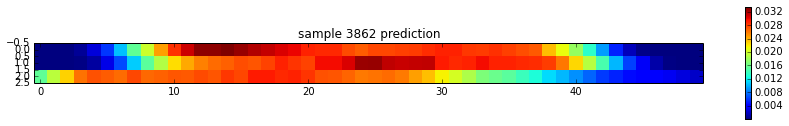

test score:
full loss: 35.8373298645
detection loss: 35.8373298645
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.728570339941



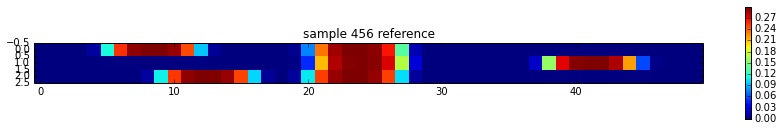

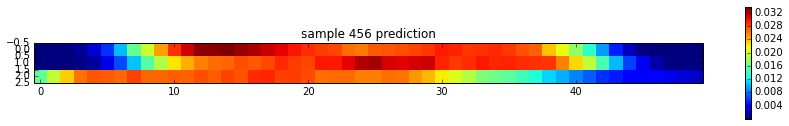

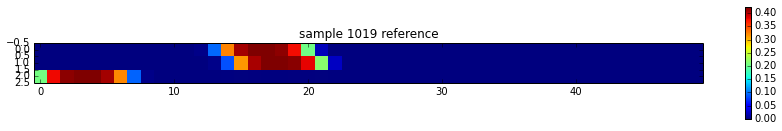

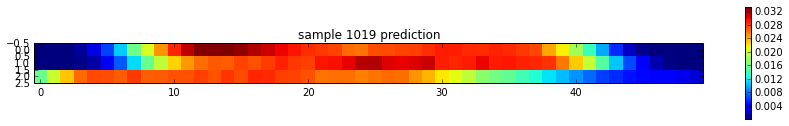

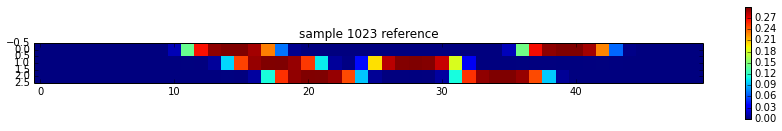

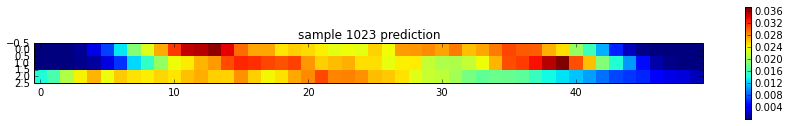

.........................
train loss during epoch 111 : 33.473408
train loss during epoch 111 : 33.155109
train loss during epoch 111 : 33.517666
train loss during epoch 111 : 34.684761
train loss during epoch 111 : 34.623116
train loss during epoch 111 : 34.417431
train loss during epoch 111 : 35.030983
train loss during epoch 111 : 34.704567
train loss during epoch 111 : 34.675125
train loss during epoch 111 : 34.645824
train loss during epoch 111 : 34.727806
train loss during epoch 111 : 34.659748
train loss during epoch 111 : 34.615463
train loss during epoch 111 : 34.381763
train loss during epoch 111 : 34.313480
train loss during epoch 111 : 34.341949
train loss during epoch 111 : 34.385902
train loss during epoch 111 : 34.431736
train loss during epoch 111 : 34.591518
train loss during epoch 111 : 34.621910
train loss during epoch 111 : 34.616447
train loss during epoch 111 : 34.680660
train loss during epoch 111 : 34.721260
train loss during epoch 111 : 34.676647
train loss dur

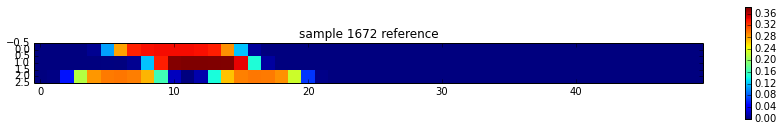

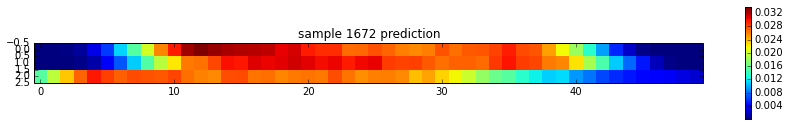

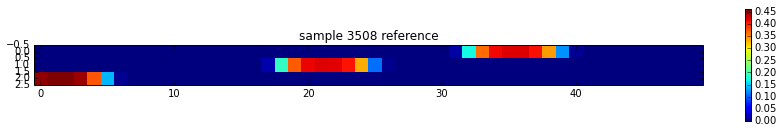

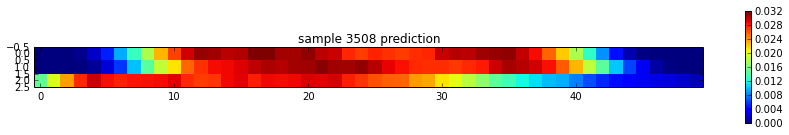

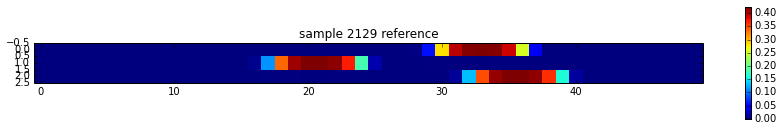

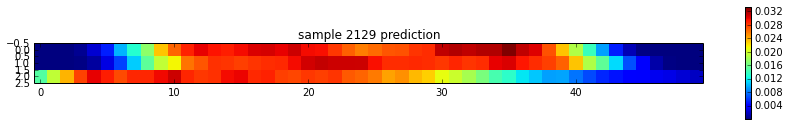

test score:
full loss: 35.9162521362
detection loss: 35.9162521362
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.727623486506



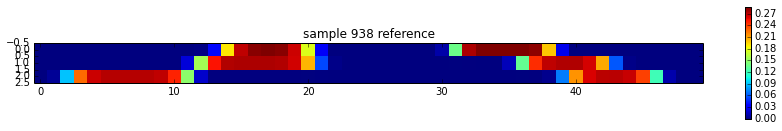

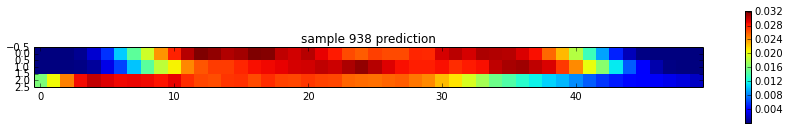

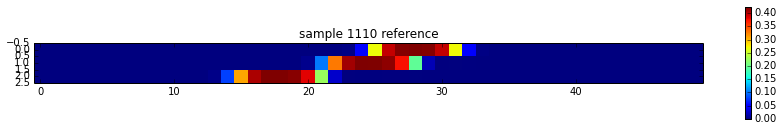

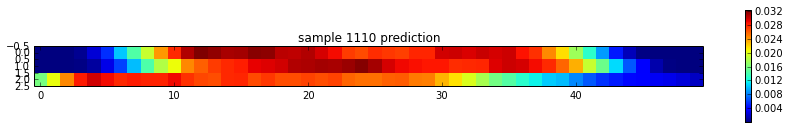

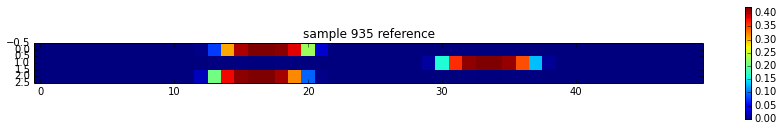

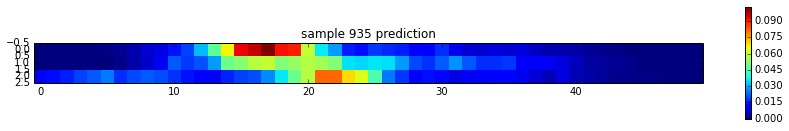

.........................
train loss during epoch 121 : 34.774075
train loss during epoch 121 : 33.689476
train loss during epoch 121 : 34.664864
train loss during epoch 121 : 35.154408
train loss during epoch 121 : 35.515095
train loss during epoch 121 : 35.458469
train loss during epoch 121 : 35.105499
train loss during epoch 121 : 35.362457
train loss during epoch 121 : 35.560104
train loss during epoch 121 : 35.204929
train loss during epoch 121 : 35.141819
train loss during epoch 121 : 35.097061
train loss during epoch 121 : 34.960152
train loss during epoch 121 : 34.952862
train loss during epoch 121 : 34.861816
train loss during epoch 121 : 34.928169
train loss during epoch 121 : 34.839260
train loss during epoch 121 : 34.821522
train loss during epoch 121 : 34.959869
train loss during epoch 121 : 35.022308
train loss during epoch 121 : 35.055672
train loss during epoch 121 : 35.101025
train loss during epoch 121 : 35.107464
train loss during epoch 121 : 34.975098
train loss dur

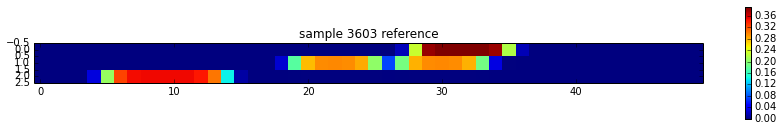

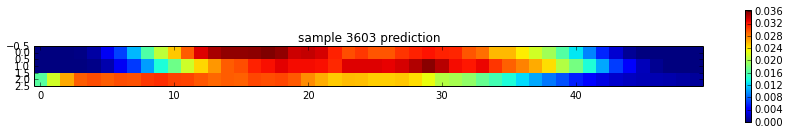

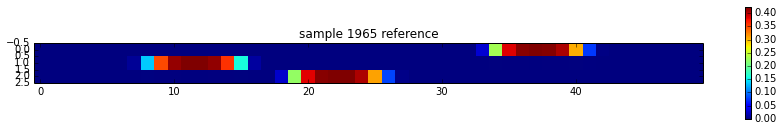

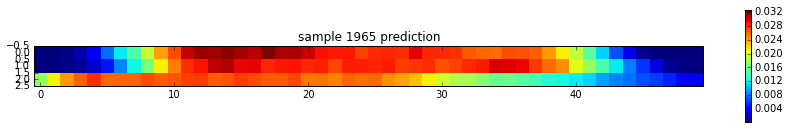

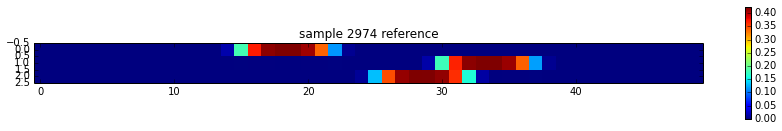

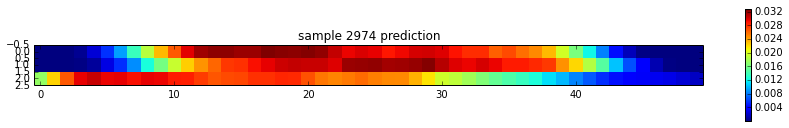

test score:
full loss: 36.0773582458
detection loss: 36.0773582458
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.725671065847



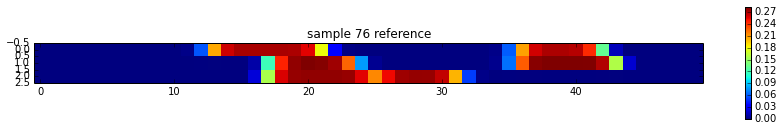

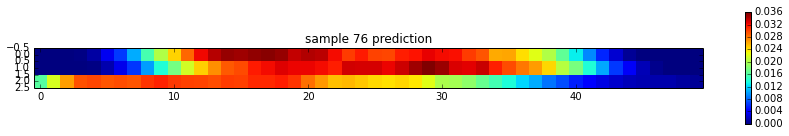

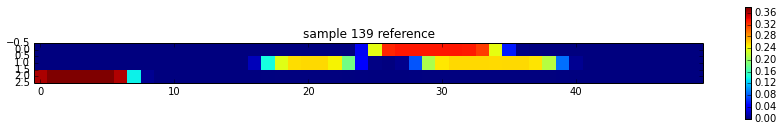

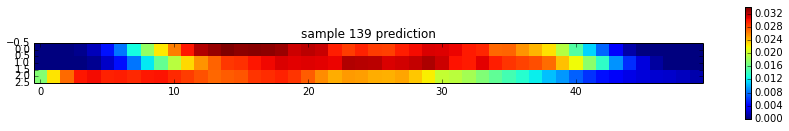

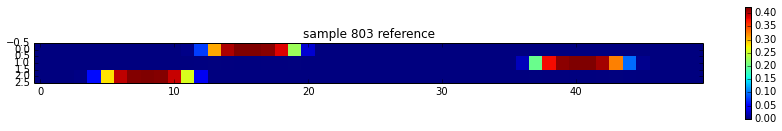

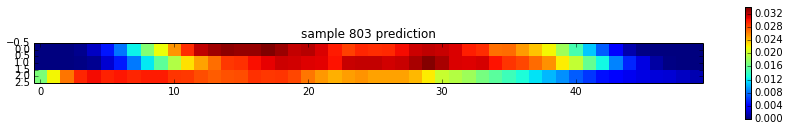

.........................
train loss during epoch 131 : 35.113575
train loss during epoch 131 : 35.805603
train loss during epoch 131 : 34.560696
train loss during epoch 131 : 34.433514
train loss during epoch 131 : 34.796120
train loss during epoch 131 : 35.002338
train loss during epoch 131 : 35.065468
train loss during epoch 131 : 35.411827
train loss during epoch 131 : 35.176685
train loss during epoch 131 : 34.914951
train loss during epoch 131 : 34.635536
train loss during epoch 131 : 34.406914
train loss during epoch 131 : 34.233566
train loss during epoch 131 : 34.373817
train loss during epoch 131 : 34.349628
train loss during epoch 131 : 34.580002
train loss during epoch 131 : 34.554054
train loss during epoch 131 : 34.650265
train loss during epoch 131 : 34.772655
train loss during epoch 131 : 34.663570
train loss during epoch 131 : 34.572868
train loss during epoch 131 : 34.765659
train loss during epoch 131 : 34.790016
train loss during epoch 131 : 34.828480
train loss dur

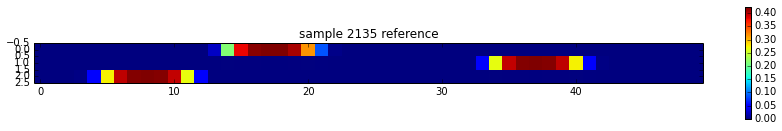

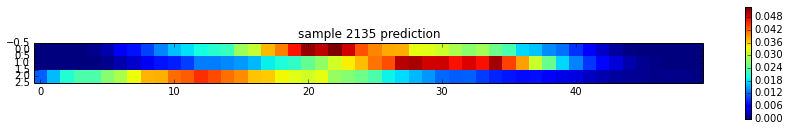

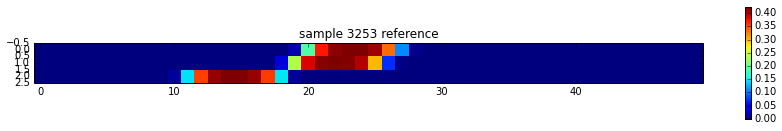

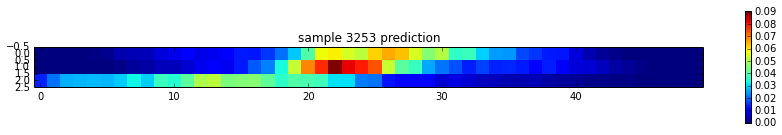

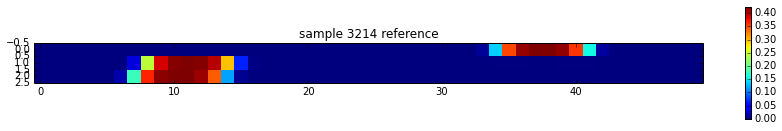

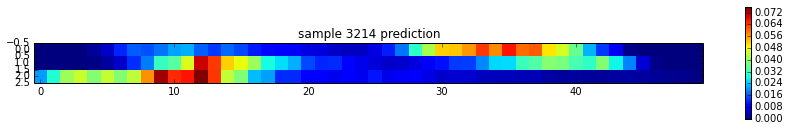

test score:
full loss: 36.1936302185
detection loss: 36.1936302185
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.724883947895



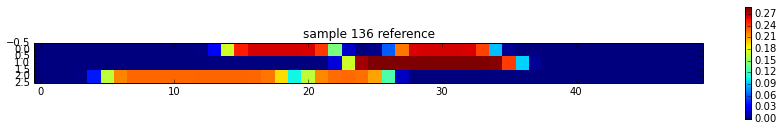

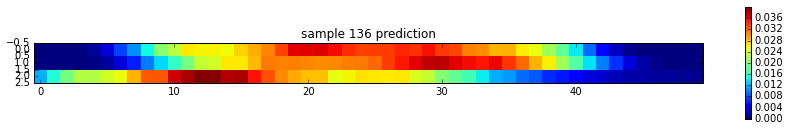

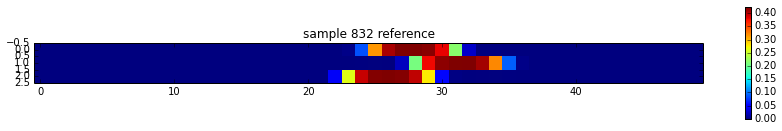

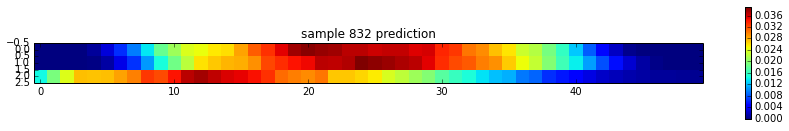

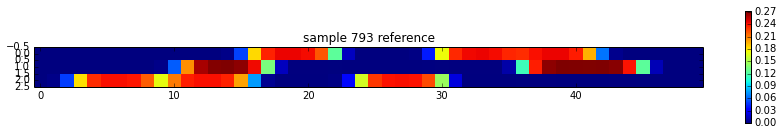

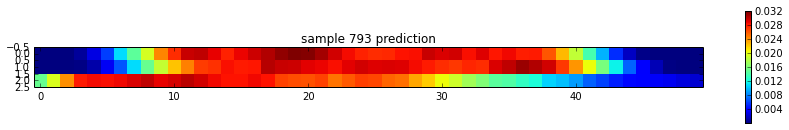

.........................
train loss during epoch 141 : 35.909679
train loss during epoch 141 : 34.389244
train loss during epoch 141 : 34.774921
train loss during epoch 141 : 34.292782
train loss during epoch 141 : 33.947029
train loss during epoch 141 : 34.398911
train loss during epoch 141 : 34.436176
train loss during epoch 141 : 34.396812
train loss during epoch 141 : 34.065647
train loss during epoch 141 : 34.238411
train loss during epoch 141 : 34.207851
train loss during epoch 141 : 34.238876
train loss during epoch 141 : 34.058159
train loss during epoch 141 : 33.990791
train loss during epoch 141 : 34.155266
train loss during epoch 141 : 34.144276
train loss during epoch 141 : 34.004917
train loss during epoch 141 : 34.086308
train loss during epoch 141 : 33.924721
train loss during epoch 141 : 34.036278
train loss during epoch 141 : 34.043106
train loss during epoch 141 : 34.036034
train loss during epoch 141 : 34.018299
train loss during epoch 141 : 34.054081
train loss dur

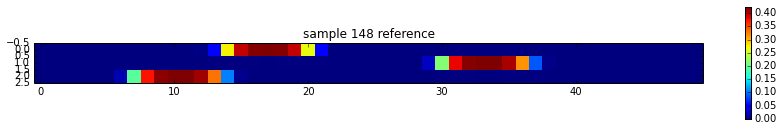

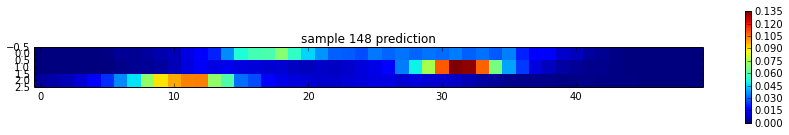

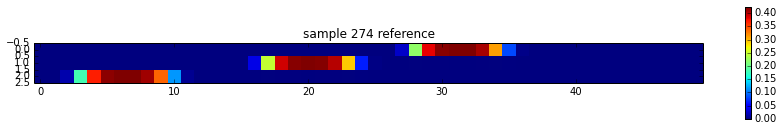

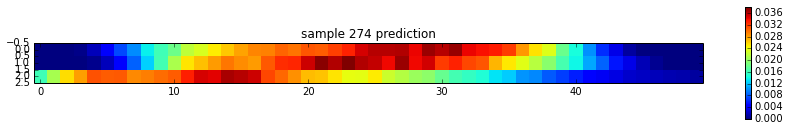

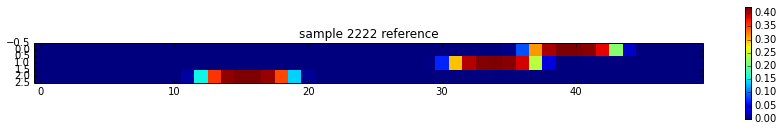

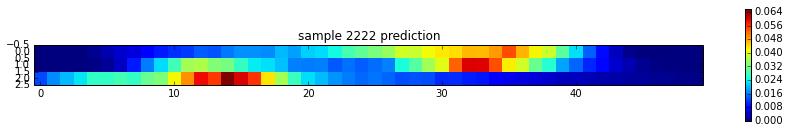

test score:
full loss: 36.3094177246
detection loss: 36.3094177246
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.723793045099



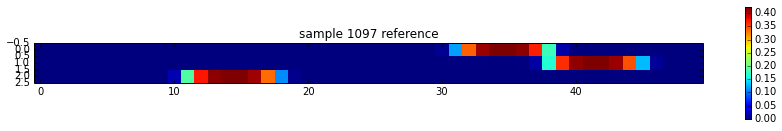

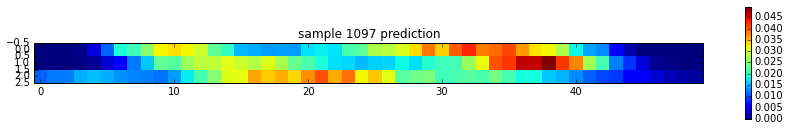

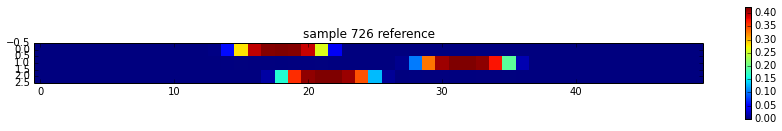

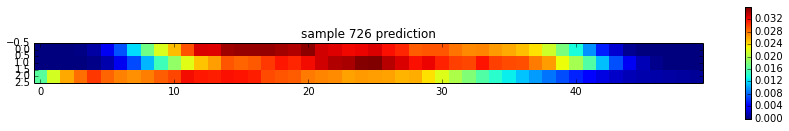

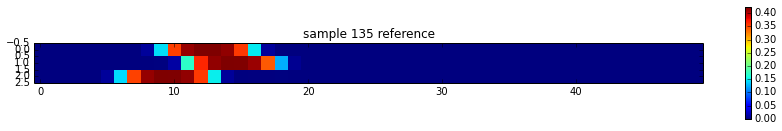

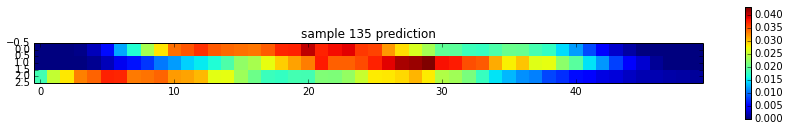

.........................
train loss during epoch 151 : 35.481560
train loss during epoch 151 : 34.630348
train loss during epoch 151 : 34.139671
train loss during epoch 151 : 33.981354
train loss during epoch 151 : 34.322739
train loss during epoch 151 : 34.730587
train loss during epoch 151 : 35.065350
train loss during epoch 151 : 34.874290
train loss during epoch 151 : 34.477966
train loss during epoch 151 : 34.250854
train loss during epoch 151 : 34.274567
train loss during epoch 151 : 34.307720
train loss during epoch 151 : 34.310909
train loss during epoch 151 : 34.178215
train loss during epoch 151 : 34.210739
train loss during epoch 151 : 34.254566
train loss during epoch 151 : 34.196869
train loss during epoch 151 : 34.182728
train loss during epoch 151 : 34.301933
train loss during epoch 151 : 34.356564
train loss during epoch 151 : 34.348358
train loss during epoch 151 : 34.399391
train loss during epoch 151 : 34.376671
train loss during epoch 151 : 34.362461
train loss dur

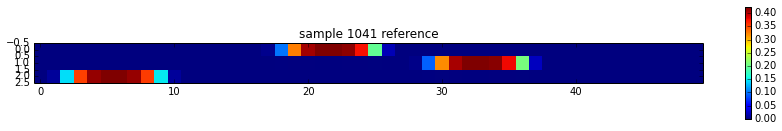

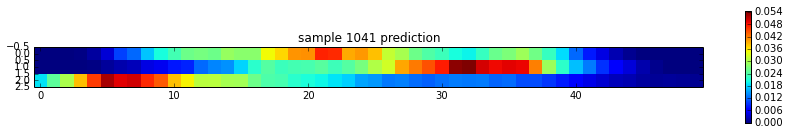

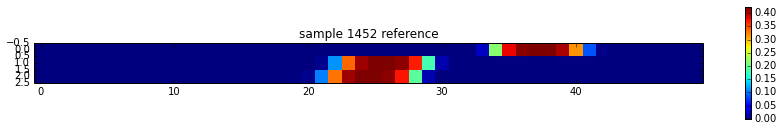

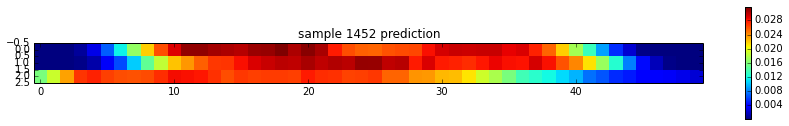

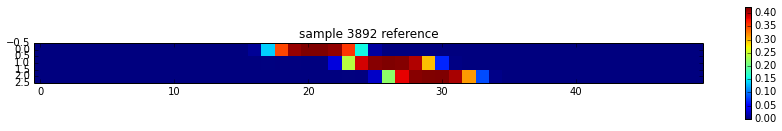

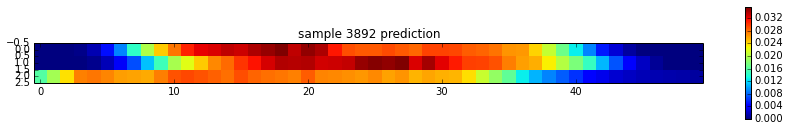

test score:
full loss: 36.3451957703
detection loss: 36.3451957703
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.720349443644



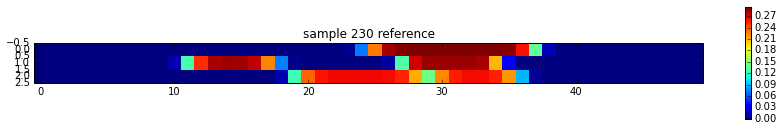

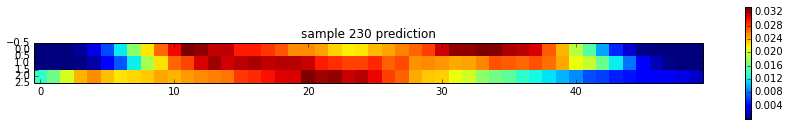

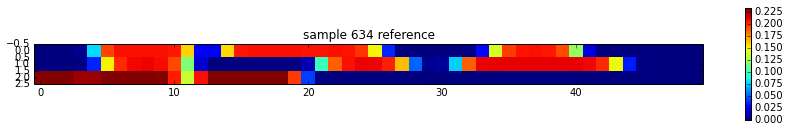

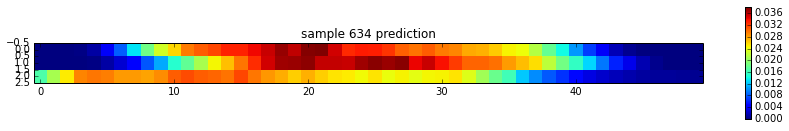

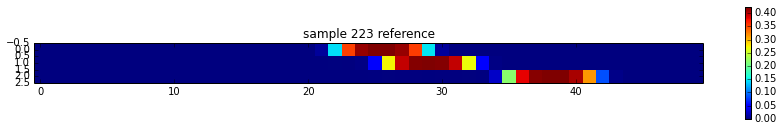

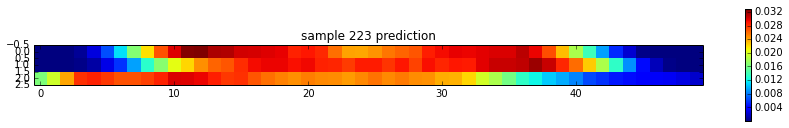

.........................
train loss during epoch 161 : 34.796154
train loss during epoch 161 : 33.791672
train loss during epoch 161 : 33.940414
train loss during epoch 161 : 33.665173
train loss during epoch 161 : 33.865051
train loss during epoch 161 : 34.230148
train loss during epoch 161 : 34.221779
train loss during epoch 161 : 34.422005
train loss during epoch 161 : 34.249115
train loss during epoch 161 : 34.382030
train loss during epoch 161 : 34.122211
train loss during epoch 161 : 34.206699
train loss during epoch 161 : 34.237221
train loss during epoch 161 : 34.206825
train loss during epoch 161 : 34.156261
train loss during epoch 161 : 33.985447
train loss during epoch 161 : 34.053638
train loss during epoch 161 : 34.001804
train loss during epoch 161 : 34.048676
train loss during epoch 161 : 34.048687
train loss during epoch 161 : 34.080566
train loss during epoch 161 : 34.023098
train loss during epoch 161 : 34.036308
train loss during epoch 161 : 34.141689
train loss dur

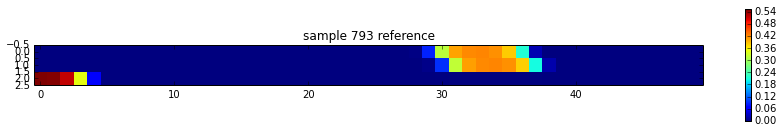

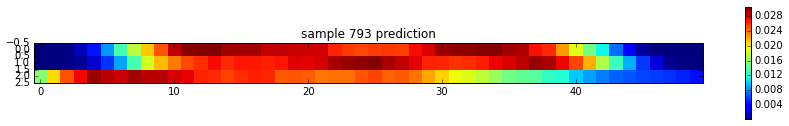

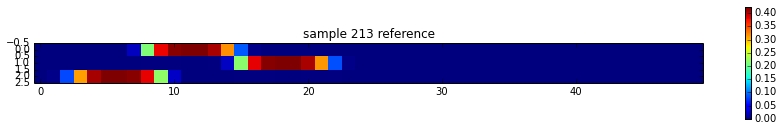

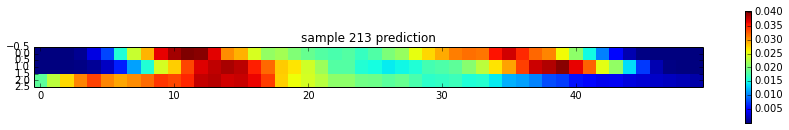

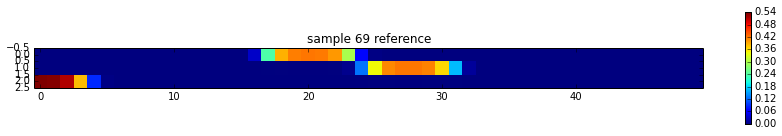

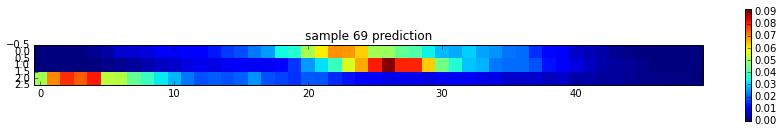

test score:
full loss: 36.375202179
detection loss: 36.375202179
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.721239844556



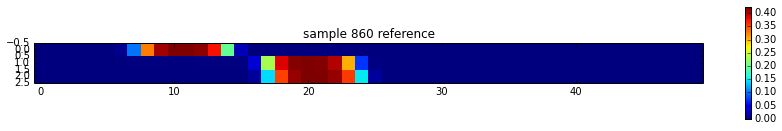

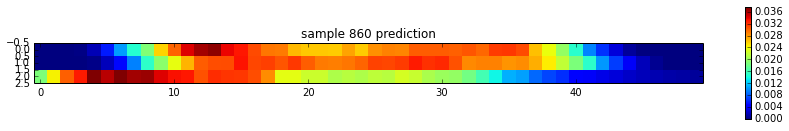

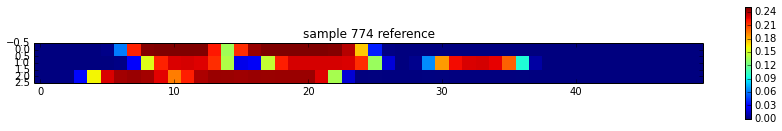

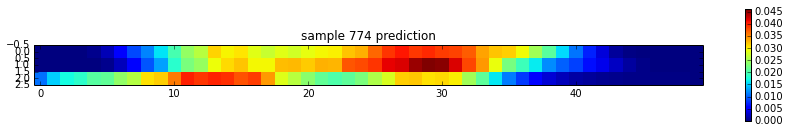

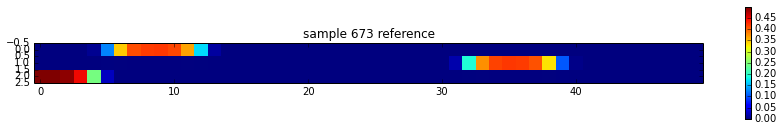

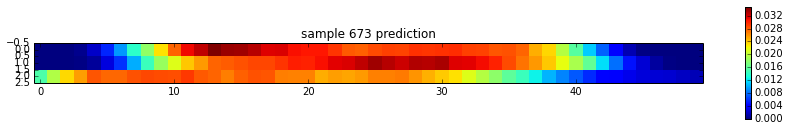

.........................
train loss during epoch 171 : 36.092655
train loss during epoch 171 : 36.234833
train loss during epoch 171 : 36.035656
train loss during epoch 171 : 34.924789
train loss during epoch 171 : 35.408710
train loss during epoch 171 : 35.130505
train loss during epoch 171 : 35.064293
train loss during epoch 171 : 34.985065
train loss during epoch 171 : 34.321201
train loss during epoch 171 : 34.449764
train loss during epoch 171 : 34.198605
train loss during epoch 171 : 34.093838
train loss during epoch 171 : 34.030674
train loss during epoch 171 : 34.026558
train loss during epoch 171 : 34.011543
train loss during epoch 171 : 33.912292
train loss during epoch 171 : 33.959820
train loss during epoch 171 : 33.909081
train loss during epoch 171 : 33.912319
train loss during epoch 171 : 33.969074
train loss during epoch 171 : 34.053703
train loss during epoch 171 : 33.887741
train loss during epoch 171 : 33.948566
train loss during epoch 171 : 33.940762
train loss dur

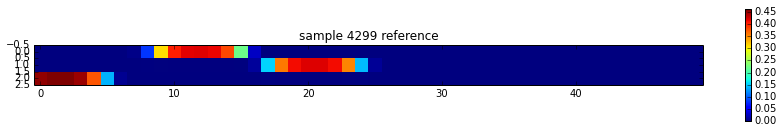

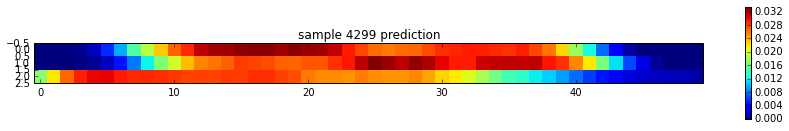

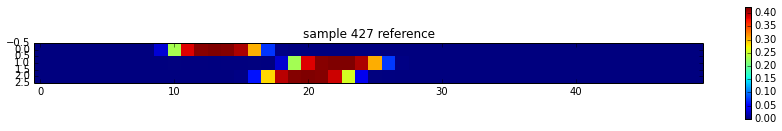

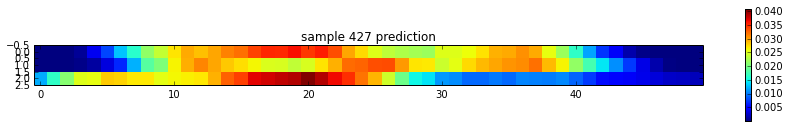

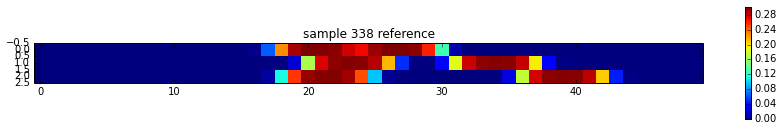

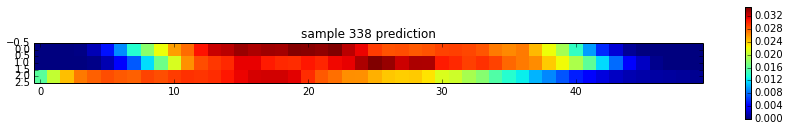

test score:
full loss: 36.6017036438
detection loss: 36.6017036438
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.718586292904



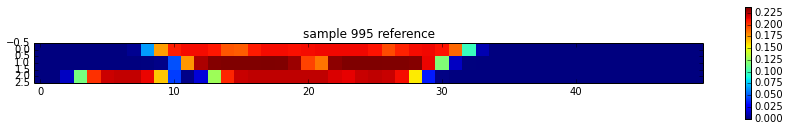

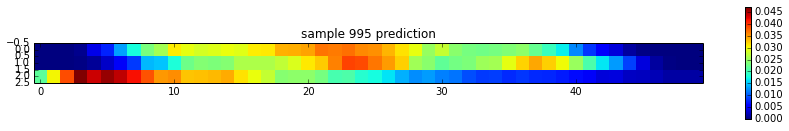

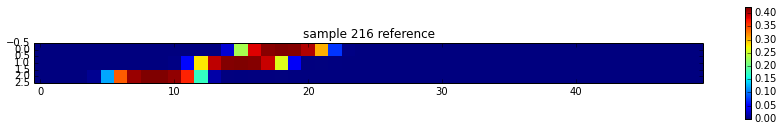

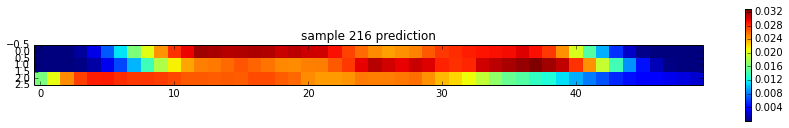

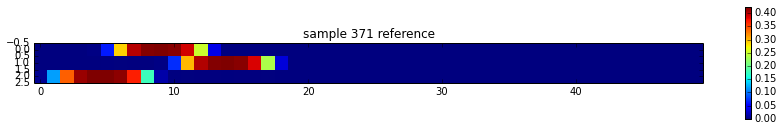

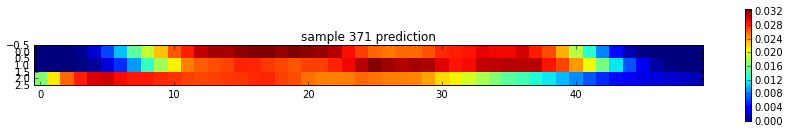

.........................
train loss during epoch 181 : 37.117493
train loss during epoch 181 : 34.973358
train loss during epoch 181 : 34.891575
train loss during epoch 181 : 34.904129
train loss during epoch 181 : 34.563320
train loss during epoch 181 : 34.505379
train loss during epoch 181 : 34.158428
train loss during epoch 181 : 34.089798
train loss during epoch 181 : 33.944607
train loss during epoch 181 : 33.860741
train loss during epoch 181 : 33.884369
train loss during epoch 181 : 33.976284
train loss during epoch 181 : 33.942375
train loss during epoch 181 : 33.967644
train loss during epoch 181 : 33.868919
train loss during epoch 181 : 33.945824
train loss during epoch 181 : 33.943794
train loss during epoch 181 : 34.076439
train loss during epoch 181 : 33.989765
train loss during epoch 181 : 33.990383
train loss during epoch 181 : 33.962608
train loss during epoch 181 : 33.815533
train loss during epoch 181 : 33.794830
train loss during epoch 181 : 33.810925
train loss dur

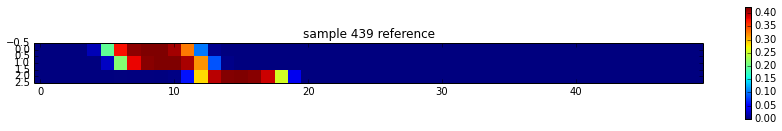

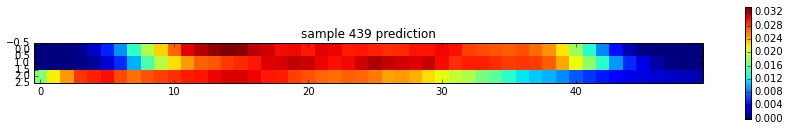

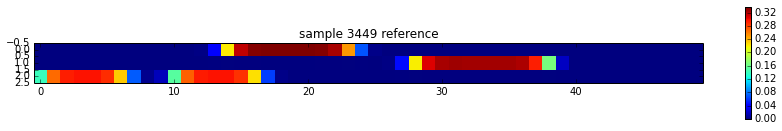

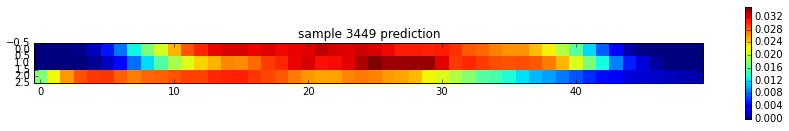

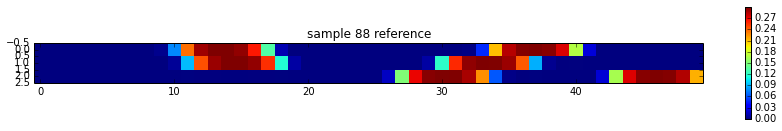

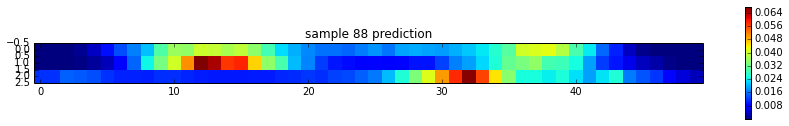

test score:
full loss: 36.8073539734
detection loss: 36.8073539734
entropy penalty: 0.0
l2 penalty: 0.0
pseudo-auc 0.717530929802



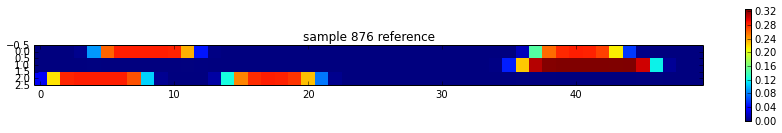

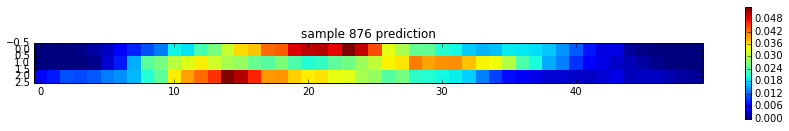

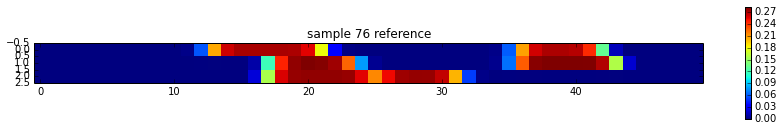

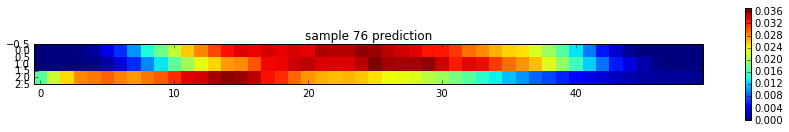

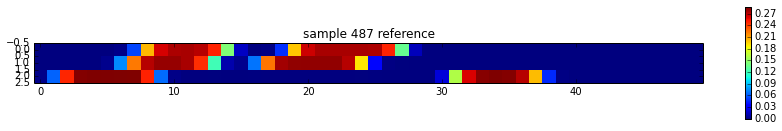

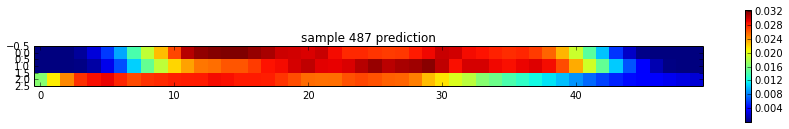

.........................
train loss during epoch 191 : 32.296349
train loss during epoch 191 : 34.566116
train loss during epoch 191 : 34.516048
train loss during epoch 191 : 33.777889
train loss during epoch 191 : 34.088699
train loss during epoch 191 : 33.940712
train loss during epoch 191 : 33.732170
train loss during epoch 191 : 33.899124
train loss during epoch 191 : 33.853607
train loss during epoch 191 : 33.682755
train loss during epoch 191 : 33.675323
train loss during epoch 191 : 33.743473
train loss during epoch 191 : 33.904827
train loss during epoch 191 : 34.027794
train loss during epoch 191 : 33.884426
train loss during epoch 191 : 33.742050
train loss during epoch 191 : 33.706078
train loss during epoch 191 : 33.676586
train loss during epoch 191 : 33.677784
train loss during epoch 191 : 33.630527
train loss during epoch 191 : 33.645859
train loss during epoch 191 : 33.753849
train loss during epoch 191 : 33.662418
train loss during epoch 191 : 33.717831
train loss dur

KeyboardInterrupt: 

In [25]:
n_epochs= 500
batch_size = 100
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(train_fun(batch_X,batch_y))
    
    
        print 'train loss during epoch %i : %f'%(epochCounter,np.mean(err))
    if epochCounter%10==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print

        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print



        print 'train score:'
        train_scores[epochCounter] = evaluate(Xtr,Ytr)
        print

        show_sample_predictions(Xtr,Ytr,count=3)

        print 'test score:'
        test_scores[epochCounter] = evaluate(Xts,Yts)
        print
        show_sample_predictions(Xts,Yts,count=3)
        print '.'*25

    epochCounter+=1



In [1]:
keys,values = zip(*sorted(train_scores.items()))
values = np.hstack(values)
plt.plot(keys,values,label="train")
keys,values = zip(*sorted(test_scores.items()))
values = np.hstack(values)
plt.plot(keys,values,label="test")
plt.legend()
plt.grid()
plt.title("50-batch case")
#plt.xlim(0,200)

plt.show()



NameError: name 'train_scores' is not defined

In [35]:
#2try: two separate training algos (updates) for network and discriminator, 
#each of them updating only a part of network weights. 
#The generator updates from discriminator function can have negative learning rate OR just a minus somewhere along the path


#also try to find out whether gradient updates are indeed opposite in case reversal layer is there
_domain_update.eval({
        _input_image_pair:Xtr,
        _target:Ytr,
    })

NameError: name '_domain_update' is not defined

# Final evaluation

Final scores on the training set:
full loss: 0.328615605831
detection loss: 0.328615605831
entropy penalty: 0.0
l2 penalty: 0.0


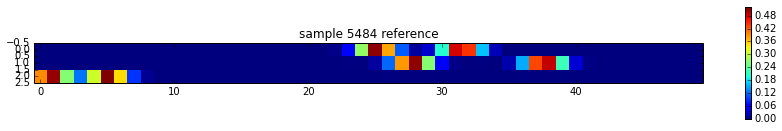

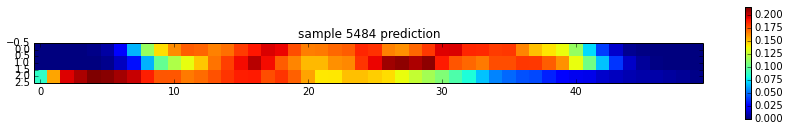

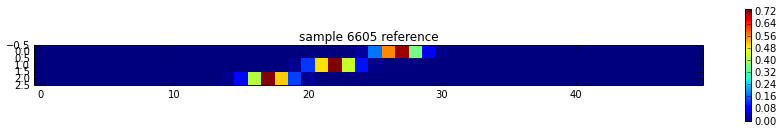

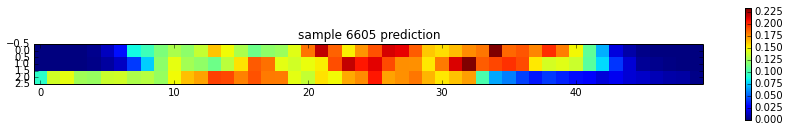

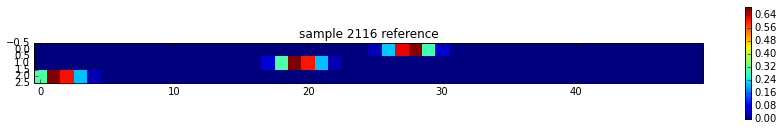

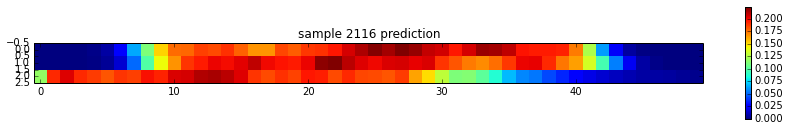

Final scores on the test set:
full loss: 0.336462974548
detection loss: 0.336462974548
entropy penalty: 0.0
l2 penalty: 0.0


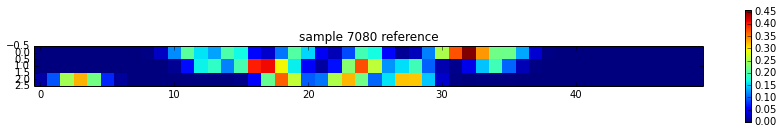

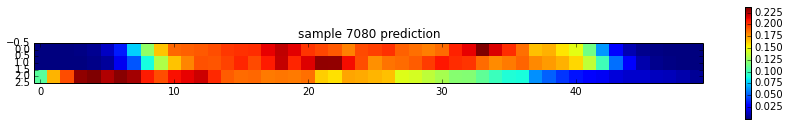

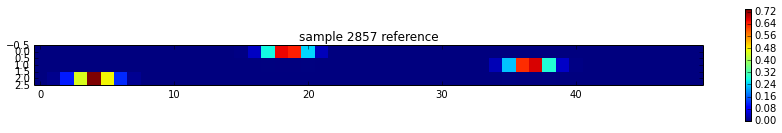

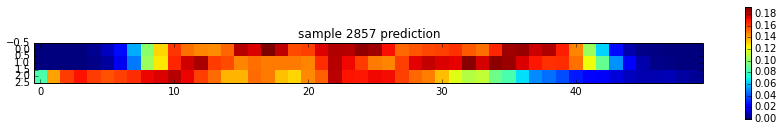

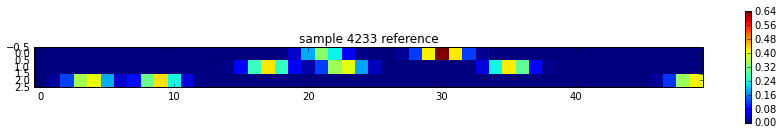

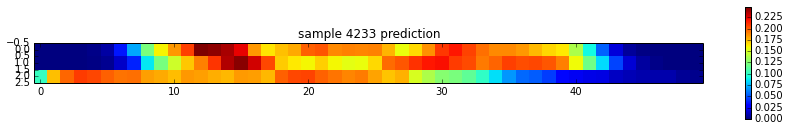

In [29]:
print "Final scores on the training set:"
evaluate(Xtr,Ytr)

show_sample_predictions(Xtr,Ytr,3)

print "Final scores on the test set:"
evaluate(Xts,Yts)

show_sample_predictions(Xts,Yts,3)

# brief conclusion
TODO

In [ ]:
# here the notebook ends

In [ ]:
ww = _nn_weights[0].get_value().T.reshape(-1,64,32)

In [ ]:
from random import choice
i = choice(range(100))
plt.figure(figsize=[7,14])
plt.imshow(ww[i],cmap='bone')
plt.colorbar()
print i


# gradient reversal trick
used here to make network output more like the actual activation map

In [31]:
prefix = "discriminator."

_reference_input_layer = lasagne.layers.InputLayer(shape = output_shape,name='reference',
                                input_var=_target)

#add reverse grad layer on top of the main nn
_disc_nn = ReverseGradientLayer(_nn,1.,
                                      name=prefix+'reversal_layer')


#mix predicted and reference activations
_disc_nn = lasagne.layers.concat([_disc_nn,_reference_input_layer],axis=1)
_disc_nn = lasagne.layers.reshape(_disc_nn,[-1]+output_shape[1:])
#now the predicted and reference activation pics are intertwined (pred,ref,pred,ref,...)




#maybe a convnet here?
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,128,
                                           name=prefix+"dense0",
                                           nonlinearity=lasagne.nonlinearities.tanh)
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,1,
                                           name = prefix+"output",
                                           nonlinearity=lasagne.nonlinearities.sigmoid)





In [32]:
_domain_prediction  = lasagne.layers.get_output(_disc_nn)


In [33]:
_domain_reference = T.repeat(T.constant(np.array([[1,0]])),_target.shape[0],axis=0)
_domain_reference = _domain_reference.reshape([-1,1])


_domain_loss = lasagne.objectives.categorical_crossentropy(_domain_prediction,_domain_reference).mean()



In [34]:
_all_weights = lasagne.layers.get_all_params(_disc_nn, trainable = True)
_disc_weights = [param for param in _all_weights if param not in _nn_weights]

_disc_weights


[discriminator.dense0.W,
 discriminator.dense0.b,
 discriminator.output.W,
 discriminator.output.b]

In [ ]:
#try out binary crossentropy for mail NN? - after finding out how exactly it is computed
_domain_update = lasagne.updates.nesterov_momentum(_domain_loss,
                                               params = _all_weights,
                                               learning_rate = .01
                                              )



In [ ]:
# compiled optimization algorithm
domain_train_fun = theano.function([_input_image_pair,_target],
                            _domain_loss,
                            updates=_domain_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )



In [ ]:
n_epochs= 500
batch_size = 500
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(domain_train_fun(batch_X,batch_y))
    
    
    print 'train loss: ',np.mean(err)
    if epochCounter%25==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print
        
        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print
        
        
        
        show_sample_predictions(Xtr,Ytr,count=3)
    
    epochCounter+=1

